In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import norm
from scipy.special import gamma as gamma_func
from scipy.special import beta as beta_func
from scipy.special import gammaln, xlogy
from scipy.integrate import quad
import tikzplotlib as tpl
np.random.seed(42)

In [4]:
# Make inline plots vector graphics
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

#matplotlib.rc("font", **{"family": "serif", "serif": ["Times Roman"]})
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts} \usepackage{amsmath}"

# Dirichlet Bridge

In [7]:
## functions

def softmax_transform(x):
    
    exp_ = np.exp(x)
    return(exp_/exp_.sum())

def dirichlet_pdf(x, alpha):
    
    alpha = np.array(alpha)
    x = np.array(x)
    coef = np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))  

    return(np.exp(- coef+ np.sum((xlogy(alpha-1, x.T)).T, 0)))

def dirichlet_t_softmax_pdf(x, alpha):
    
    alpha = np.array(alpha)
    x_sm = softmax_transform(np.array(x))
    coef = np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))
    
    return(np.exp(- coef+ np.sum((xlogy(alpha, x_sm.T)).T, 0)))

def dirichlet_mu(alpha):
    alpha = np.array(alpha)
    K = len(alpha)
    return((alpha-1)/(alpha.sum()- K))
    
def dirichlet_Sigma(alpha):
    alpha = np.array(alpha)
    K = len(alpha)
    diag_ = (alpha - 1)/(alpha.sum() - K)**2
    S = np.diag(diag_)
    return(S)
    
# softmax basis

def dirichlet_t_softmax_mu(alpha):
    
    alpha = np.array(alpha)
    log_ = np.log(alpha)
    K = len(alpha)
    return(log_ - 1/K * log_.sum())
    
def dirichlet_t_softmax_Sigma(alpha):
    
    alpha = np.array(alpha)
    K = len(alpha)
    inv_alpha_sum = (1/alpha).sum()
    
    Sigma = np.zeros((K, K))
    for k in range(K):
        for l in range(K):
            v = -1/K * (1/alpha[k] + 1/alpha[l] - 1/K * inv_alpha_sum)
            if k == l:
                v += 1/alpha[k]
            Sigma[k, l] =  v
            
    return(Sigma)

#"""
def inverse_softmax_transform_all(y,c=1):
    
    x = log(y) * c
    return(x)

def inverse_softmax_transform_all(y):
    # Note: the softmax function is not bijective, hence has not one inverse.
    # inverses have the form of (log(x_0), log(x_1), ...) * C
    # since we assume sum(x) = 0 we can only choose x = log(y) - 1/K * sum(log(y))
    # We assume to receive an array of values drawn from the Dirichlet which we can transform
    
    x = np.log(y) - np.mean(np.log(y), 1).reshape(-1, 1)
    assert(np.allclose(x.sum(1), np.zeros(len(y))))
    
    return(x)

def inverse_softmax_transform_single(y):
    
    x = np.log(y) - np.mean(np.log(y))
    assert(np.allclose(x.sum(), 0))
    
    return(x)
#"""

#"""
from scipy.stats import multivariate_normal as mv_norm
def fake_inverse_softmax_Gaussian_pdf(y, mu, Sigma):
    
    x = inverse_softmax_transform_single(y)
    
    K = np.shape(x)[-1]
    ones = np.ones(K)
    mu_bar = mu - (Sigma @ np.outer(ones, ones) @ mu)/(ones @ Sigma @ ones)
    Sigma_bar = Sigma - (Sigma @ np.outer(ones, ones) @ Sigma)/(ones @ Sigma @ ones)
    Sigma_bar += 1e-8*np.eye(K)
    
    det_ = 1/K * np.prod(1/(y[:-1]))
    m = np.zeros((K-1, K-1))
    for i in range(K-1):
        for j in range(K-1):
            m[i,j] = - 1/K * 1/y[i]
            if i == j: m[i,j] += 1/y[i]
    #print(m)
    #print(np.diag(y[:-1]) - 1/K * np.outer(np.ones(K-1), y[:-1]))
    det2_ = np.linalg.det(m)
    #print("det: ", det_)
    #print("det2: ", det2_)
    
    return(mv_norm.pdf(x, mu_bar, Sigma_bar) * det2_)

def softmax_Gaussian_pdf(x, mu, Sigma):
    
    K = len(mu)
    sm_x = softmax_transform(x)
    Jac = np.zeros((K,K))
    for i in range(K):
        for j in range(K):
            Jac[i,j] = -sm_x[i]*sm_x[j]
            if i == j:
                Jac[i,j] += sm_x[i]
                
    det_ = np.linalg.det(Jac)
    print(det_)
    y = mv_norm.pdf(sm_x, mu, Sigma) #* det_
    return(y)

#"""

In [8]:
y_test = np.random.random((3,3))
y_test_single = np.random.random(3)
x_test = inverse_softmax_transform_all(y_test)
x_test_single = inverse_softmax_transform_single(y_test_single)
print(x_test)
print(x_test_single)

[[-0.53386266  0.39765202  0.13621065]
 [ 0.89652874 -0.44818706 -0.44834167]
 [-1.67970248  1.02250224  0.65720024]]
[ 1.07445066 -2.46355785  1.38910719]


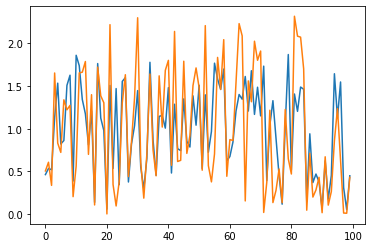

In [9]:
from scipy.stats import dirichlet

a = [1,2,3]
dir_samples = dirichlet.rvs(a, size=100)
dir_pdf = np.array([dirichlet.pdf(s, a) for s in dir_samples])
mu = dirichlet_t_softmax_mu(a)
Sigma = dirichlet_t_softmax_Sigma(a) + 1e-8*np.eye(len(a))
norm_pdf = np.array([fake_inverse_softmax_Gaussian_pdf(y_, mu, Sigma) for y_ in dir_samples])
plt.plot(dir_pdf/dir_pdf.mean())
plt.plot(norm_pdf/norm_pdf.mean())

In [10]:
test_alpha = np.array([1.1, 1.1, 1.1])
test_Sigma = dirichlet_t_softmax_Sigma(test_alpha)
print(test_Sigma)

def is_sem_pos_def(x):
    eig = np.linalg.eigvals(x)
    pd = np.all(eig >= 0)
    if not pd:
        raise(ValueError("matrix is not positive semi-definite! Matrix: {}; Eigenvalues: {}".format(x, eig)))
    else:
        return(True)
    
is_sem_pos_def(test_Sigma+np.eye(3)*1e-8)

[[ 0.60606061 -0.3030303  -0.3030303 ]
 [-0.3030303   0.60606061 -0.3030303 ]
 [-0.3030303  -0.3030303   0.60606061]]


True

1.0177351456992338e-18
-2.1811782398148522e-18
-3.093262320642532e-18
3.9561867331123636e-18
3.1616643618439692e-18
-4.172766153183739e-18
1.918901705327872e-18
7.311164520368316e-19
1.6879806624330833e-18
-2.5575846972878385e-18
5.6276796060225764e-18
-2.4727356816357834e-18
9.829794609446426e-19
3.9048898723412445e-18
-5.882908108684482e-18
7.264703309294684e-19
-2.7508151496249254e-18
-2.521442610805221e-18
0.0
6.000804631544624e-18
0.0
6.851493308273582e-19
4.732871705685666e-18
0.0
1.2672237749103868e-18
1.6940793852107886e-18
7.246161155046818e-19
1.0053672266190507e-18
-5.899557946770073e-18
-2.1828559514571927e-18
-3.833303853156775e-18
9.095485587004075e-19
0.0
-3.0805887329601712e-18
-1.6119698691398365e-18
5.81507095435472e-18
7.433054254615714e-18
-1.658368153512412e-18
0.0
-3.941020215938141e-18
-5.806221843892459e-18
2.29616946999175e-18
-6.2430973178659176e-18
-1.6840255807953185e-18
7.178340120041708e-19
9.7756068508622e-19
-1.675728692278672e-18
5.10305751916139e-18
7.

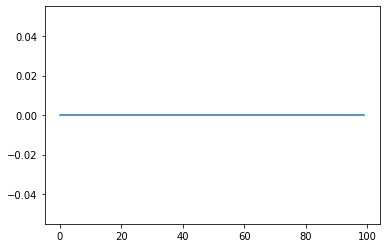

In [11]:
norm_pdf2 = np.array([softmax_Gaussian_pdf(y_, mu, Sigma) for y_ in dir_samples])
plt.plot(norm_pdf2)

In [12]:
def beta_mu(a, b):
    return((a-1)/(a+b-2))

def beta_var(a, b):
    return(((a-1)*(b-1))/(a+b-2)**3)

"""transform: logit"""

def logit_transform(theta):
    return(np.log(theta/(1-theta)))

def logit_derivative(x):
    return(1/x + 1/(1-x))

def logistic_transform(a):
    return(1 / (1 + np.exp(-a)))

def logistic_derivative(x):
    return(logistic_transform(x) * (1- logistic_transform(x)))

def beta_t_logit_mu(a,b):
    return(np.log(a/b))

def beta_t_logit_var(a,b):
    return((a+b)/(a*b))

def beta_t_logit_pdf(x, a, b):
    x_t = logistic_transform(x)
    nom = (x_t) ** (a) * (1- x_t) ** (b)
    denom = beta_func(a, b)
    return((nom/denom))

def logit_normal_back(x, mu, sigma):
    x_ = logit_transform(x)
    return(norm.pdf(x_, mu, sigma) * logit_derivative(x))

In [11]:
## plotting

def plot_dirichlet_t_softmax(params, save=False, filename='dirichlet_softmax_bridge.pdf', show_back=True):
    
    a1 = params[0] 
    a2 = params[1] 
    a3 = params[2] 
    
    x_ = np.linspace(0,1, 1000 +1)
    x = np.array([[x_i, 1-x_i] for x_i in x_])
    
    print("using only 2D Dirichlet for plotting (i.e. the special case of the Beta dist.)")
    
    mode1 = dirichlet_mu(a1)[0]
    mode2 = dirichlet_mu(a2)[0]
    mode3 = dirichlet_mu(a3)[0]
    
    beta_sigma1 = np.sqrt(beta_var(a1[0], a1[1]))
    beta_sigma2 = np.sqrt(beta_var(a2[0], a2[1]))
    beta_sigma3 = np.sqrt(beta_var(a3[0], a3[1]))
    
    print(beta_sigma2, beta_sigma3)

    y1 = np.array([dirichlet_pdf(_, a1) for _ in x])
    y2 = np.array([dirichlet_pdf(_, a2) for _ in x])
    y3 = np.array([dirichlet_pdf(_, a3) for _ in x])
    
    print(np.shape(y1))
    
    LP_approx1 = norm.pdf(x_, mode1, beta_sigma1)
    LP_approx2 = norm.pdf(x_, mode2, beta_sigma2)
    LP_approx3 = norm.pdf(x_, mode3, beta_sigma3)
    
    print(np.shape(LP_approx1))

    #plot 2: transform to other base
    x_t = np.linspace(-4,4, 1000 + 1)
    
    y1_t_logit = beta_t_logit_pdf(x_t, a1[0], a1[1])
    y2_t_logit = beta_t_logit_pdf(x_t, a2[0], a2[1])
    y3_t_logit = beta_t_logit_pdf(x_t, a3[0], a3[1])

    mode1_t_logit = beta_t_logit_mu(a1[0], a1[1])
    mode2_t_logit = beta_t_logit_mu(a2[0], a2[1])
    mode3_t_logit = beta_t_logit_mu(a3[0], a3[1])

    sigma1_t_logit = np.sqrt(beta_t_logit_var(a1[0], a1[1]))
    sigma2_t_logit = np.sqrt(beta_t_logit_var(a2[0], a2[1]))
    sigma3_t_logit = np.sqrt(beta_t_logit_var(a3[0], a3[1]))

    LP_approx1_t_logit = norm.pdf(x_t, mode1_t_logit, sigma1_t_logit)
    LP_approx2_t_logit = norm.pdf(x_t, mode2_t_logit, sigma2_t_logit)
    LP_approx3_t_logit = norm.pdf(x_t, mode3_t_logit, sigma3_t_logit)
    
    
    #plot 3: transform back and reconstruct
    if show_back:
        y1_back = logit_normal_back(x_, mode1_t_logit, sigma1_t_logit)
        y2_back = logit_normal_back(x_, mode2_t_logit, sigma2_t_logit)
        y3_back = logit_normal_back(x_, mode3_t_logit, sigma3_t_logit)

    """Plots"""
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=15)
    plt.rc('axes', labelsize=15)
    
    legend_size=14
    xlabel_size=15
    ylabel_size=15
    title_size=15
    lw_size=2
    
    if show_back:
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(23, 6))
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(20, 4))
    #plot beta distribution and LPA in the standard basis
    axs[0].plot(x_, y1, 'r-', lw=lw_size)
    axs[0].plot(x_, y2, 'b-', lw=lw_size)
    axs[0].plot(x_, y3, 'k-', lw=lw_size, label='$\mathcal{D}$')
    axs[0].plot(x_, LP_approx1, 'r--', lw=lw_size)
    axs[0].plot(x_, LP_approx2, 'b--', lw=lw_size)
    axs[0].plot(x_, LP_approx3, 'k--', lw=lw_size, label='$\mathcal{N}$')
    axs[0].set_yticklabels([])
    axs[0].set_yticks([])
    axs[0].set_xlabel('$\pi$', fontsize=xlabel_size)
    axs[0].set_ylabel('$p(\pi)d\pi$', fontsize=ylabel_size)
    axs[0].set_title('Laplace in standard basis', fontsize=title_size)
    axs[0].legend(prop={'size': legend_size});

    #plot beta distribution in the transformed basis
    axs[1].plot(x_t, y1_t_logit, 'r-', lw=lw_size)
    axs[1].plot(x_t, y2_t_logit, 'b-', lw=lw_size)
    axs[1].plot(x_t, y3_t_logit, 'k-', lw=lw_size, label='$\mathcal{D}$')
    axs[1].plot(x_t, LP_approx1_t_logit, 'r--', lw=lw_size)
    axs[1].plot(x_t, LP_approx2_t_logit, 'b--', lw=lw_size)
    axs[1].plot(x_t, LP_approx3_t_logit, 'k--', lw=lw_size, label='$\mathcal{N}$')
    axs[1].set_xlabel('x', fontsize=xlabel_size)
    axs[1].set_ylabel('$p(x)dx$', fontsize=ylabel_size)
    axs[1].set_yticklabels([])
    axs[1].set_yticks([])
    axs[1].set_title('Laplace in inverse-softmax basis', fontsize=title_size)
    axs[1].legend(prop={'size': legend_size});

    #plot backwards transformation of the LPA from the transformed to the standard basis
    if show_back:
        axs[2].plot(x_, y1, 'r-', lw=lw_size)
        axs[2].plot(x_, y2, 'b-', lw=lw_size)
        axs[2].plot(x_, y3, 'k-', lw=lw_size, label='$\mathcal{D}$')
        axs[2].plot(x_, y1_back, 'r--', lw=lw_size)
        axs[2].plot(x_, y2_back, 'b--', lw=lw_size)
        axs[2].plot(x_, y3_back, 'k--', lw=lw_size, label='$\mathcal{N}$')
        axs[2].set_yticklabels([])
        axs[2].set_yticks([])
        axs[2].set_xlabel('$\pi$', fontsize=xlabel_size)
        axs[2].set_ylabel('$p(\pi)d\pi$', fontsize=ylabel_size)
        axs[2].set_title('Transformation back to standard basis', fontsize=title_size)
        axs[2].legend(prop={'size': legend_size});

    plt.tight_layout()
    #plt.show()
    #plt.savefig('BetaVizTransformation.pdf')
    #tpl.save('BetaVizTransformation.tex', figure=fig, tex_relative_path_to_data='.figures', figurewidth='\\figwidth', figureheight='\\figheight',
    #         extra_axis_parameters={'xtick align=inside', 'ytick align=inside', 'xtick pos=left', 'ytick pos=left', 'legend pos=north east'})

    if save:
        plt.savefig(filename)

using only 2D Dirichlet for plotting (i.e. the special case of the Beta dist.)
0.2721655269759087 0.1870439059165649
(1001,)
(1001,)


/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/home/marius/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/marius/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys

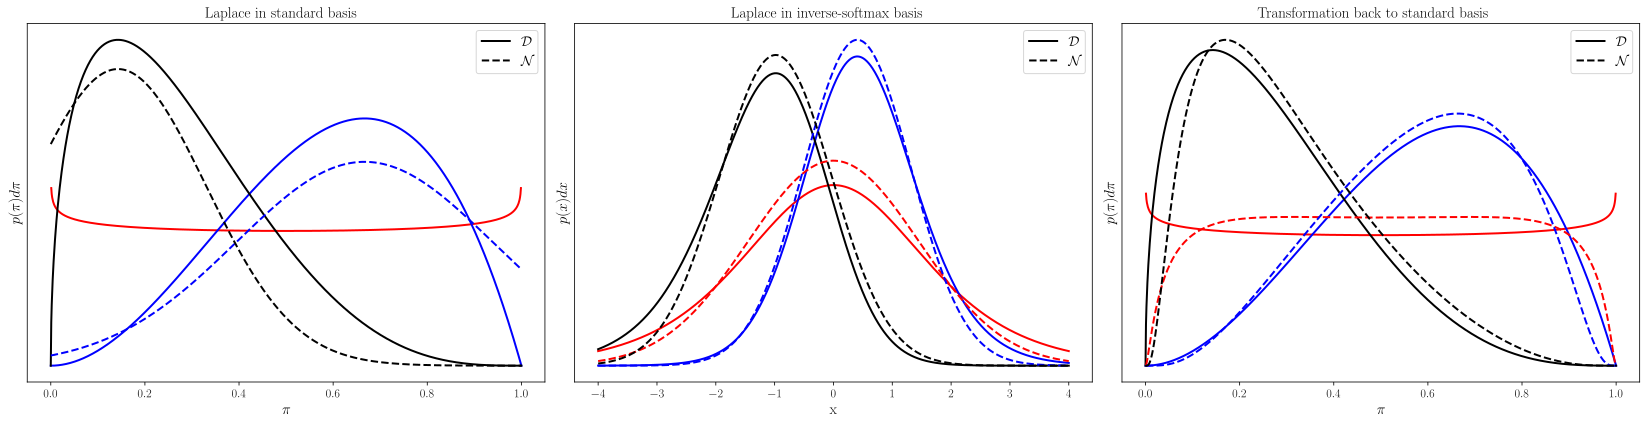

In [12]:
plot_dirichlet_t_softmax(params=[[0.95, 0.95], [3,2], [1.5, 4]], save=True, filename='dirichlet_softmax_bridge.pdf', show_back=True)

# Verify the Bridge

In [13]:
def alpha_from_normal(mu, Sigma):
    
    Sigma_diag = np.diagonal(Sigma)
    sum_mu_exp = np.sum(np.exp(-mu))
    K = len(mu)
    return(1/Sigma_diag * (1 - 2/K + np.exp(mu)/K**2 * sum_mu_exp))

test_a1 = np.array([1,2,3,4])
test_m1, test_S1 = dirichlet_t_softmax_mu(test_a1), dirichlet_t_softmax_Sigma(test_a1)
test_a2 = alpha_from_normal(test_m1, test_S1)
print(test_a2)

test_a3 = np.random.random(4)
test_m3, test_S3 = dirichlet_t_softmax_mu(test_a3), dirichlet_t_softmax_Sigma(test_a3)
test_a4 = alpha_from_normal(test_m3, test_S3)

assert(np.allclose(test_a3, test_a4))

[1. 2. 3. 4.]


# Statistical distance measures

In [14]:
from torch_two_sample import MMDStatistic
from scipy.stats import norm, beta, dirichlet
from scipy.stats import multivariate_normal as mv_norm
import torch

## MMD from 100 combinations of parameters

In [15]:
def MMD_combinations(params, plot=False, n_samples=1000, verbose=True):
    
    As = params
    
    MMD_sum = 0
    MMD_t_softmax_sum = 0 

    for a in As:
            
        if verbose:
            print("a: ", a)
                
        if np.sum(a < 1) != 0:
            print("a_i < 1 doesn't yield a Laplace Approximation in standard basis")

        if np.sum(a) == len(a):
            print("sum of alphas is K, division by zero -> break")
            MMD_ = torch.Tensor([np.nan])
            MMD_softmax_ = torch.Tensor([np.nan])
            
        else:
            #get samples from all dists
            #standard
            D_samples = dirichlet.rvs(a, size=n_samples)
            if np.sum(a < 1) == 0:                
                mode1 = dirichlet_mu(a)
                Sigma1 = dirichlet_Sigma(a)
                N_samples = mv_norm.rvs(mode1, Sigma1, size=n_samples)

            #softmax
            mode1_softmax = dirichlet_t_softmax_mu(a)
            Sigma1_softmax = dirichlet_t_softmax_Sigma(a)
            D_samples_softmax = inverse_softmax_transform_all(D_samples)
            #D_samples_softmax = inverse_softmax_transform(D_samples)
            #we align the means of the normal and the inverse softmax transform since we don't know the
            #exact value of the constant for the inversion c
            N_samples_softmax = mv_norm.rvs(mode1_softmax, Sigma1_softmax, size=n_samples)
            N_samples_softmax += np.mean(D_samples_softmax, axis=1).reshape(-1, 1)
            #print(np.shape(np.mean(D_samples_softmax, axis=1)))


            #calculate MMD for all bases
            MMD = MMDStatistic(n_samples, n_samples)

            #standard
            D_samples_ = torch.Tensor(D_samples.reshape((n_samples, -1)))
            if np.sum(a < 1) == 0:
                N_samples_ = torch.Tensor(N_samples.reshape((n_samples, -1)))
                MMD_ = MMD(D_samples_, N_samples_,  alphas=[0.5], ret_matrix=False)
                MMD_ = torch.max(torch.zeros(1), MMD_)
            else:
                MMD_ = torch.Tensor([np.nan])

            #softmax
            D_samples_softmax_ = torch.Tensor(D_samples_softmax.reshape((n_samples, -1)))
            N_samples_softmax_ = torch.Tensor(N_samples_softmax.reshape((n_samples, -1)))
            MMD_softmax_= MMD(D_samples_softmax_, N_samples_softmax_,  alphas=[0.5], ret_matrix=False)

            #why?
            MMD_softmax_= torch.max(torch.zeros(1), MMD_softmax_)


            if plot:
                print("plot the marginal of the first entry for the Dirichlet (which is a beta distribution)")
                n_bins = int(np.sqrt(n_samples))
                fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(23, 6))
                axs[0].hist(D_samples[:,0], bins = n_bins, alpha=0.5, label='$\mathcal{B}$')
                axs[0].hist(N_samples[:,0], bins = n_bins, alpha=0.5, label='$\mathcal{N}$')
                axs[0].set_title('standard basis')
                axs[0].legend()

                axs[1].hist(D_samples_softmax[:,0], bins = n_bins, alpha=0.5, label='$\mathcal{B}$')
                axs[1].hist(N_samples_softmax[:,0], bins = n_bins, alpha=0.5, label='$\mathcal{N}$')
                axs[1].set_title('inverse softmax basis')
                axs[1].legend()

                plt.show()

            if verbose: 
                print("standard: ", MMD_.item(), "softmax: ", MMD_softmax_.item())

        #add them to their respective sums
        MMD_sum += MMD_
        MMD_t_softmax_sum += MMD_softmax_
        
    return(MMD_sum, MMD_t_softmax_sum)
    #return(MMD_sum.item(), MMD_t_softmax_sum.item())

In [16]:
np.random.seed(42)
random_params = np.random.uniform(low=1.0, high=3.0, size=(100, 4))
MMD_combinations(params=random_params, plot=False, verbose=True, n_samples=2000)

a:  [1.74908024 2.90142861 2.46398788 2.19731697]
standard:  0.009322106838226318 softmax:  0.002699941396713257
a:  [1.31203728 1.31198904 1.11616722 2.73235229]
standard:  0.08663374185562134 softmax:  0.011543124914169312
a:  [2.20223002 2.41614516 1.04116899 2.9398197 ]
standard:  0.023017585277557373 softmax:  0.006278097629547119
a:  [2.66488528 1.42467822 1.36364993 1.36680902]
standard:  0.05393171310424805 softmax:  0.006269246339797974
a:  [1.60848449 2.04951286 1.86389004 1.58245828]
standard:  0.016904175281524658 softmax:  0.004031717777252197
a:  [2.22370579 1.27898772 1.5842893  1.73272369]
standard:  0.03467839956283569 softmax:  0.003283977508544922
a:  [1.91213997 2.57035192 1.39934756 2.02846888]
standard:  0.017300128936767578 softmax:  0.0057239830493927
a:  [2.18482914 1.09290083 2.2150897  1.34104825]
standard:  0.05053192377090454 softmax:  0.006091713905334473
a:  [1.13010319 2.89777107 2.93126407 2.6167947 ]
standard:  0.014562606811523438 softmax:  0.00887143

standard:  0.04219841957092285 softmax:  0.0065825581550598145
a:  [1.10336344 2.06270926 2.08127024 2.2748598 ]
standard:  0.026914358139038086 softmax:  0.005495846271514893
a:  [2.45218267 2.95170416 2.0326007  1.64591295]
standard:  0.010020256042480469 softmax:  0.0053389668464660645
a:  [2.59037239 1.5416645  1.87794284 1.15691276]
standard:  0.038450539112091064 softmax:  0.006466716527938843
a:  [1.05070149 2.92529683 2.67196024 2.39194841]
standard:  0.018179893493652344 softmax:  0.0094948410987854
a:  [1.81790589 1.34658864 1.31287409 1.5004858 ]
standard:  0.04625582695007324 softmax:  0.007831335067749023
a:  [2.09845333 2.42919185 2.32039475 1.55986779]
standard:  0.01126408576965332 softmax:  0.00404706597328186
a:  [2.90973056 2.47579383 2.10870811 2.22344149]
standard:  0.004775285720825195 softmax:  0.002327054738998413
a:  [1.83920012 1.49546198 1.71194536 2.51569222]
standard:  0.0184975266456604 softmax:  0.005518704652786255
a:  [1.02878698 1.23214528 1.09200528 1

(tensor([3.4221]), tensor([0.6018]))

In [17]:
results_MMD = np.array([3.4221, 0.6018])
results_MMD_normed = results_MMD/results_MMD[0]
print(results_MMD_normed)

[1.         0.17585693]


## KL-divergence (mode seeking/backward, from samples)

In [18]:
from scipy.stats import dirichlet
from scipy.stats import multivariate_normal as mv_norm

a_test = np.array([3,2,1])

In [19]:
def KL_div_samples_dirichlet(a, num_samples, softmax=False, plot=False, eps=1e-8):
    
    dirichlet_samples = dirichlet.rvs(a, size=num_samples)
    num_bins = int(np.cbrt(num_samples)) #third root of num_samples
    
    if softmax:
    
        dir_samples_inv_sm = inverse_softmax_transform_all(dirichlet_samples)
        mu_dir_inv_sm = dirichlet_t_softmax_mu(a)
        Sigma_dir_inv_sm = dirichlet_t_softmax_Sigma(a)
        print(Sigma_dir_inv_sm)
        norm_samples = mv_norm.rvs(mu_dir_inv_sm, Sigma_dir_inv_sm, size=num_samples)

        q_min = np.array([norm_samples[:, i].min() for i in range(len(a))])
        q_max = np.array([norm_samples[:, i].max() for i in range(len(a))])
        p_min = np.array([dir_samples_inv_sm[:, i].min() for i in range(len(a))])
        p_max = np.array([dir_samples_inv_sm[:, i].max() for i in range(len(a))])
        
        #half the size of the histogram per dimensions
        q_min += 0.25 * (q_max - q_min)
        q_max -= 0.25 * (q_max - q_min)
        p_min += 0.25 * (p_max - p_min)
        p_max -= 0.25 * (p_max - p_min)
        
        rangedd = [[np.min([q_min[i], p_min[i]]), np.max([q_max[i], p_max[i]])] for i in range(len(a))]

        p_hist, _ = np.histogramdd(dir_samples_inv_sm, density=True, bins=[num_bins,num_bins,num_bins], range=rangedd)
        q_hist, _ = np.histogramdd(norm_samples, density=True, bins=[num_bins,num_bins,num_bins], range=rangedd)

        KL_div = np.mean(p_hist * np.log((p_hist + eps)/(q_hist + eps)))
        
        if plot:
            print("plotting a 1D marginal of the Dirichlet which is a Beta")
            plt.plot(p_hist[4,:,4], label='phist')
            plt.plot(q_hist[4,:,4], label='qhist')
            plt.legend()
            plt.show()

        return(KL_div)
    
    else:
    
        mu_dir = dirichlet_mu(a)
        Sigma_dir = dirichlet_Sigma(a)
        norm_samples = mv_norm.rvs(mu_dir, Sigma_dir, size=num_samples)

        q_min = np.array([norm_samples[:, i].min() for i in range(len(a))])
        q_max = np.array([norm_samples[:, i].max() for i in range(len(a))])
        p_min = np.array([dirichlet_samples[:, i].min() for i in range(len(a))])
        p_max = np.array([dirichlet_samples[:, i].max() for i in range(len(a))])
        
        #half the size of the histogram per dimensions
        q_min += 0.25 * (q_max - q_min)
        q_max -= 0.25 * (q_max - q_min)
        p_min += 0.25 * (p_max - p_min)
        p_max -= 0.25 * (p_max - p_min)
        
        rangedd = [[np.min([q_min[i], p_min[i]]), np.max([q_max[i], p_max[i]])] for i in range(len(a))]

        p_hist, _ = np.histogramdd(dirichlet_samples, density=True, bins=[num_bins,num_bins,num_bins], range=rangedd)
        q_hist, _ = np.histogramdd(norm_samples, density=True, bins=[num_bins,num_bins,num_bins], range=rangedd)

        KL_div = np.mean(p_hist * np.log((p_hist + eps)/(q_hist + eps) ))
        
        if plot:
            print("plotting a 1D marginal of the Dirichlet which is a Beta")
            plt.plot(p_hist[4,:,4], label='phist')
            plt.plot(q_hist[4,:,4], label='qhist')
            plt.legend()
            plt.show()

        return(KL_div)



plotting a 1D marginal of the Dirichlet which is a Beta


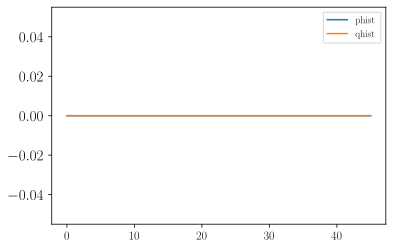

7.203085198485973
[[ 0.31481481 -0.07407407 -0.24074074]
 [-0.07407407  0.37037037 -0.2962963 ]
 [-0.24074074 -0.2962963   0.53703704]]
plotting a 1D marginal of the Dirichlet which is a Beta


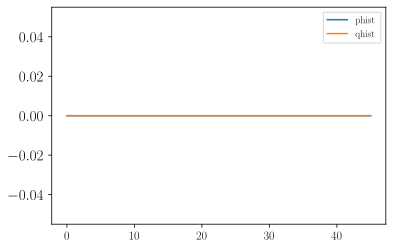

0.00422325802740317


In [20]:
print(KL_div_samples_dirichlet(a_test, 100000, plot=True))
print(KL_div_samples_dirichlet(a_test, 100000, softmax=True, plot=True))

In [21]:
def KL_div_samples_combinations(params, num_samples, plot=False, verbose=True):
    
    As = params
    
    KL_div_sum = 0
    KL_div_sm_sum = 0

    for a in As:

        if verbose:
            print("a: ", a)

        if np.min(a) < 1: #if it contains a value smaller than 1
            print("a_i < 1: not legitimate in standard base")
            KL_div_ = np.nan
        else:
            KL_div_ = KL_div_samples_dirichlet(a, num_samples=num_samples, plot=False)

        #compute KL-div for logit base
        KL_div_sm_ = KL_div_samples_dirichlet(a, num_samples=num_samples, softmax=True, plot=False)
        KL_div_sm_sum += KL_div_sm_
        KL_div_sum += KL_div_

        if verbose:
            print("standard: ", KL_div_, "inverse softmax: ", KL_div_sm_)

            
    return(KL_div_sum, KL_div_sm_sum)

In [22]:
a_s = np.array([1.1, 1.1, 1.1])
a_m = np.array([2,2,3])
a_l = np.array([8,9,10])

test_As = [a_s, a_m, a_l]
KL_div_samples_combinations(test_As, num_samples=100000, verbose=True)

a:  [1.1 1.1 1.1]
[[ 0.60606061 -0.3030303  -0.3030303 ]
 [-0.3030303   0.60606061 -0.3030303 ]
 [-0.3030303  -0.3030303   0.60606061]]
standard:  0.038917149617245 inverse softmax:  0.0014854231266588527
a:  [2 2 3]
[[ 0.31481481 -0.18518519 -0.12962963]
 [-0.18518519  0.31481481 -0.12962963]
 [-0.12962963 -0.12962963  0.25925926]]
standard:  1.2601764820842674 inverse softmax:  0.004824428303320582
a:  [ 8  9 10]
[[ 0.07901235 -0.04135802 -0.03765432]
 [-0.04135802  0.07438272 -0.03302469]
 [-0.03765432 -0.03302469  0.07067901]]
standard:  23.78678337771727 inverse softmax:  0.03848295092873364


(25.085877009418784, 0.04479280235871307)

# KL-divergence from samples attempt 2

In [23]:
from scipy.stats import beta

def KL_div_samples_dirichlet2(a, num_samples, softmax=False, plot=False, eps=1e-8):
    
    dirichlet_samples = dirichlet.rvs(a, size=num_samples)
    num_bins = int(np.cbrt(num_samples)) #third root of num samples
    
    if softmax:
    
        dir_samples_inv_sm = inverse_softmax_transform_all(dirichlet_samples)
        mu_dir_inv_sm = dirichlet_t_softmax_mu(a) 
        Sigma_dir_inv_sm = dirichlet_t_softmax_Sigma(a) + np.eye(3)*1e-8
        print("Sigma_dir_inv_sm: ", Sigma_dir_inv_sm)
        
        s = np.array(dir_samples_inv_sm)
        p_ = np.array([dirichlet_t_softmax_pdf(s_, a) for s_ in s])
        q_ = mv_norm.pdf(s, mu_dir_inv_sm, Sigma_dir_inv_sm)
        KL_div_inv_sm_ = np.mean(np.log((p_/(q_+eps) + eps)))
            
        if plot:
            x_ = np.linspace(s[:,0].min(), s[:,0].max(), 1000+1)
            plt.hist(s[:,0], density=True, bins=num_bins)
            #plt.plot(x_, dirichlet_t_softmax_pdf(x_, a)[:,0])
            #plt.plot(x_, mv_norm.pdf(x_, mu_dir_inv_sm, Sigma_dir_inv_sm)[:,0])
            plt.title('softmax-base marginal')
            plt.show();
        
        return(KL_div_inv_sm_)
    
    else:
    
        mu_dir = dirichlet_mu(a)
        Sigma_dir = dirichlet_Sigma(a)
        
        s = np.array(dirichlet_samples)
        p_ = np.array([dirichlet.pdf(s_, a) for s_ in s])
        q_ = mv_norm.pdf(s, mu_dir, Sigma_dir)
        KL_div_inv_sm_ = np.mean(np.log((p_/(q_+eps) + eps)))
            
        if plot:
            x_ = np.linspace(s[:,0].min(), s[:,0].max(), 1000+1)
            plt.hist(s[:,0], density=True, bins=num_bins)
            plt.plot(x_, beta.pdf(x_, a[0], a[1:].sum()))
            #plt.plot(x_, mv_norm.pdf(x_, mu_dir, Sigma_dir)[:,0])
            plt.title('standard-base marginal')
            plt.show();
        
        return(KL_div_inv_sm_)
        
        


In [24]:
def KL_div_samples_combinations2(params, num_samples, plot=False, verbose=True):
    
    As = params
    
    KL_div_sum = 0
    KL_div_sm_sum = 0

    for a in As:

        if verbose:
            print("a: ", a)

        if np.min(a) < 1: #if it contains a value smaller than 1
            print("a_i < 1: not legitimate in standard base")
            KL_div_ = np.nan
        else:
            KL_div_ = KL_div_samples_dirichlet2(a, num_samples=num_samples, plot=plot)

        #compute KL-div for logit base
        KL_div_sm_ = KL_div_samples_dirichlet2(a, num_samples=num_samples, softmax=True, plot=plot)
        KL_div_sm_sum += KL_div_sm_
        KL_div_sum += KL_div_

        if verbose:
            print("standard: ", KL_div_, "inverse softmax: ", KL_div_sm_)

            
    return(KL_div_sum, KL_div_sm_sum)

a:  [1.1 1.2 1.3]


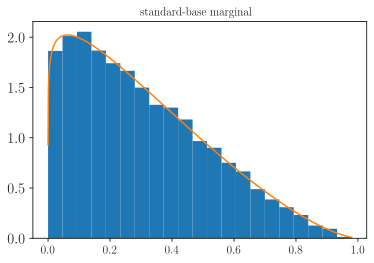

Sigma_dir_inv_sm:  [[ 0.58210309 -0.3017353  -0.28036778]
 [-0.3017353   0.55685057 -0.25511526]
 [-0.28036778 -0.25511526  0.53548305]]


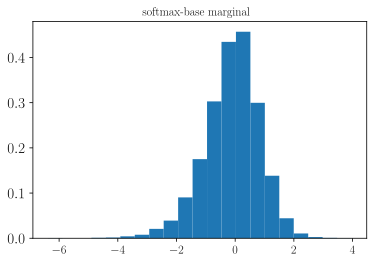

standard:  2.6585744652394783 inverse softmax:  -8.669176286673071
a:  [2 2 3]


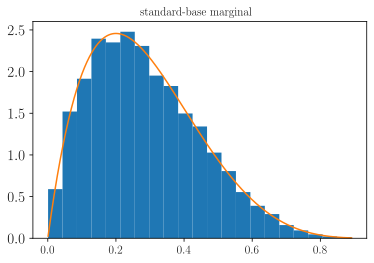

Sigma_dir_inv_sm:  [[ 0.31481482 -0.18518519 -0.12962963]
 [-0.18518519  0.31481482 -0.12962963]
 [-0.12962963 -0.12962963  0.25925927]]


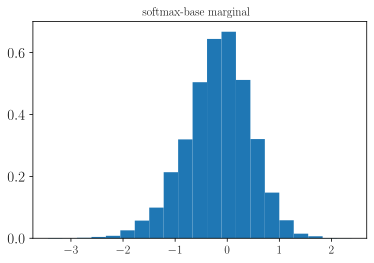

standard:  0.6040066863802032 inverse softmax:  -8.78024193059031
a:  [20 20 20]


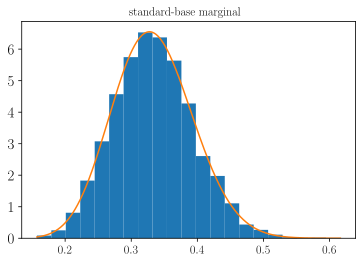

Sigma_dir_inv_sm:  [[ 0.03333334 -0.01666667 -0.01666667]
 [-0.01666667  0.03333334 -0.01666667]
 [-0.01666667 -0.01666667  0.03333334]]


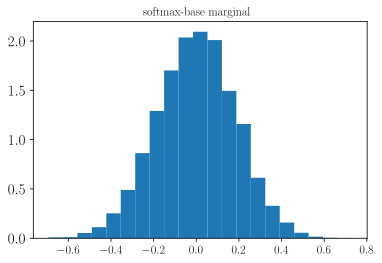

standard:  -1.0862578243997334 inverse softmax:  -8.836792002357427


(2.176323327219948, -26.28621021962081)

In [25]:
a_s = np.array([1.1, 1.2, 1.3])
a_m = np.array([2,2,3])
a_l = np.array([20, 20, 20])#np.array([8,9,10])

test_As = [a_s, a_m, a_l]
#test_As = [a_m, a_l]
KL_div_samples_combinations2(test_As, num_samples=10000, verbose=True, plot=True)

# KL-divergence from samples attempt 3

In [26]:
from scipy.stats import norm

def KL_div_samples_dirichlet3(a, num_samples, softmax=False, plot=False, eps=1e-8):
    
    dirichlet_samples = dirichlet.rvs(a, size=num_samples)
    num_bins = int(np.cbrt(num_samples)) #third root of num samples
    
    if softmax:
    
        #dir_samples_inv_sm = inverse_softmax_transform_all(dirichlet_samples)
        mu_dir_inv_sm = dirichlet_t_softmax_mu(a) 
        Sigma_dir_inv_sm = dirichlet_t_softmax_Sigma(a) + np.eye(3)*1e-8
        #print("Sigma_dir_inv_sm: ", Sigma_dir_inv_sm)
        
        s = np.array(dirichlet_samples)
        p_ = np.array([dirichlet.pdf(s_, a) for s_ in s])
        q_ = np.array([fake_inverse_softmax_Gaussian_pdf(y_, mu_dir_inv_sm, Sigma_dir_inv_sm) for y_ in s])
        p_ /= p_.mean()
        q_ /= q_.mean()
        KL_div_inv_sm_ = np.mean(np.log((p_/q_)))
            
        if plot:
            x_ = np.linspace(s[:,0].min(), s[:,0].max(), 1000+1)
            plt.hist(s[:,0], density=True, bins=num_bins)
            #q_pdf = np.array([fake_inverse_softmax_Gaussian_pdf(y_, mu_dir_inv_sm, Sigma_dir_inv_sm) for y_ in x_])
            plt.plot(x_, beta.pdf(x_, a[0], a[1:].sum()))
            #plt.plot(x_, q_pdf)
            plt.title('softmax-base marginal')
            plt.show();
        
        return(KL_div_inv_sm_)
    
    else:
    
        mu_dir = dirichlet_mu(a)
        Sigma_dir = dirichlet_Sigma(a)
        
        s = np.array(dirichlet_samples)
        #s_inv_sm = np.log(s)
        #p_ = np.array([dirichlet_t_softmax_pdf(s_, a) for s_ in s_inv_sm])
        #q_ = np.array([softmax_Gaussian_pdf(s_, mu_dir, Sigma_dir) for s_ in s_inv_sm])
        p_ = np.array([dirichlet_pdf(s_, a) for s_ in s])
        q_ = np.array([mv_norm.pdf(s_, mu_dir, Sigma_dir) for s_ in s])
        plt.plot(p_[-100:])
        plt.plot(q_[-100:])
        plt.show()
        KL_div_inv_sm_ = np.mean(np.log((p_)/(q_)))
            
        if plot:
            x_ = np.linspace(s[:,0].min(), s[:,0].max(), 1000+1)
            plt.hist(s[:,0], density=True, bins=num_bins)
            plt.plot(x_, beta.pdf(x_, a[0], a.sum() - a[0]))
            plt.plot(x_, norm.pdf(x_, mu_dir[0], np.sqrt(Sigma_dir[0,0])))
            plt.title('standard-base marginal')
            plt.show();
        
        return(KL_div_inv_sm_)
        
        


In [27]:
def KL_div_samples_combinations3(params, num_samples, plot=False, verbose=True):
    
    As = params
    
    KL_div_sum = 0
    KL_div_sm_sum = 0

    for a in As:

        if verbose:
            print("a: ", a)

        if np.min(a) < 1: #if it contains a value smaller than 1
            print("a_i < 1: not legitimate in standard base")
            KL_div_ = np.nan
        else:
            KL_div_ = KL_div_samples_dirichlet3(a, num_samples=num_samples, plot=plot)

        #compute KL-div for logit base
        KL_div_sm_ = KL_div_samples_dirichlet3(a, num_samples=num_samples, softmax=True, plot=plot)
        KL_div_sm_sum += KL_div_sm_
        KL_div_sum += KL_div_

        if verbose:
            print("standard: ", KL_div_, "inverse softmax: ", KL_div_sm_)

            
    return(KL_div_sum, KL_div_sm_sum)

a:  [1.1 1.2 1.3]


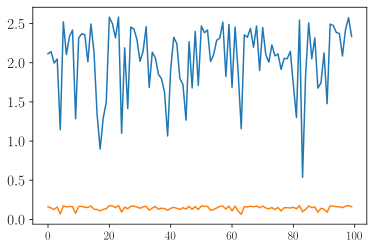

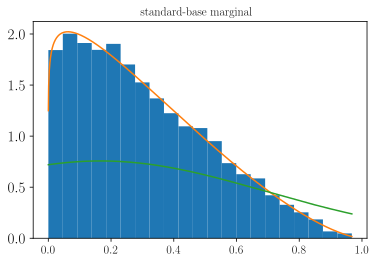

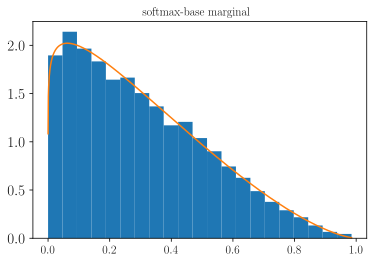

standard:  2.6584382008967107 inverse softmax:  0.5064017477949982
a:  [2 2 3]


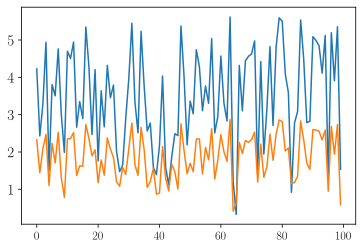

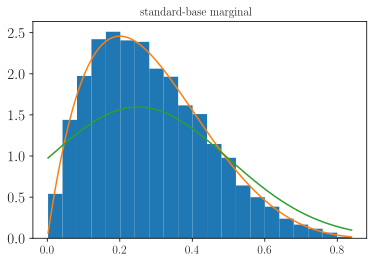

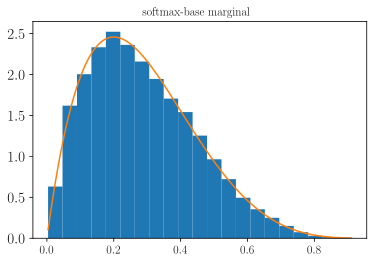

standard:  0.5979442809319389 inverse softmax:  0.2621247708056269
a:  [ 8  9 10]


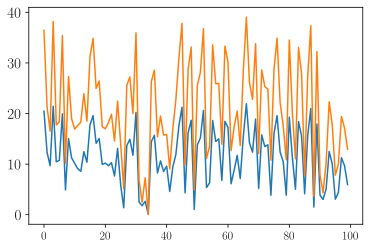

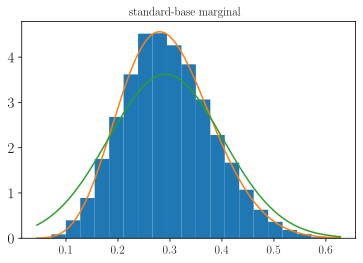

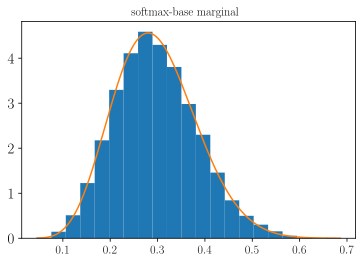

standard:  -0.6306257153801108 inverse softmax:  0.061333111662036165


(2.6257567664485384, 0.8298596302626613)

In [28]:
a_s = np.array([1.1, 1.2, 1.3])
a_m = np.array([2,2,3])
a_l = np.array([8,9,10])

test_As = [a_s, a_m, a_l]
#test_As = [a_m, a_l]
KL_div_samples_combinations3(test_As, num_samples=10000, verbose=True, plot=True)

In [29]:
a = np.array([20,20,20])
mu_test = dirichlet_mu(a)
Sigma_test = dirichlet_Sigma(a) + 1e-8*np.eye(len(a))

#x_test = np.array([1/3, 1/3, 1/3])
x_test = np.array([0.2,0.2,0.6])
print(mv_norm.pdf(x_test, mu_test, Sigma_test))
print(dirichlet.pdf(x_test, a))

0.015540477075348313
0.01290486090566415


# Plot to understand what's going on 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib 
import math
from functools import reduce
from math import gamma
from operator import mul
from scipy.special import loggamma
from scipy.stats import dirichlet, multivariate_normal

import torch
import tikzplotlib

561


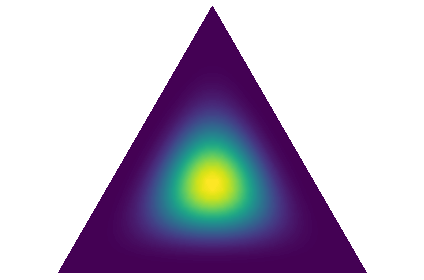

In [16]:
from scipy.special import gammaln, xlogy

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)


midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)


def softmax_transform(a):
    x = np.exp(a)/np.sum(np.exp(a))
    return(x)

def beta_function(alpha):
    return(np.exp(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha))))    

class Dirichlet(object):
    def __init__(self, alpha):
        self._alpha = np.array(alpha)
        self._coef = np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))    
        
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        return(np.exp(- self._coef+ np.sum((xlogy(self._alpha-1, x.T)).T, 0)))
    
class Normal3D(object):
    
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.array(Sigma)
        self.const = 1 / (np.sqrt((2*np.pi)**3 * np.linalg.det(Sigma)))
        
    def pdf(self, x):
        """Calculate 3D Gaussian"""
        y = self.const * np.exp(-0.5 * (x - self.mu).T @ self.Sigma @ (x - self.mu))
        return(y)
    
class logitNormal3D(object):
    
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.array(Sigma)
        self.const = 1/ (np.sqrt(np.linalg.det(2 * np.pi * self.Sigma)))
        
    def pdf(self, x):
        part_one = self.const / np.prod(x)
        logistic = logistic_transform(x)
        part_two = np.exp(-0.5*(logistic - self.mu).T @ self.Sigma @ (logistic - self.mu))
        y = part_one * part_two
        return(y)

def draw_pdf_contours(dist, filename='delete.png', nlevels=200, subdiv=5, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    xys = [xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)]
    #print(len(pvals))
    #print(xys)
    print(len(xys))

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show();
    
draw_pdf_contours(Dirichlet([5, 5, 5]))

In [17]:
def argmin_norm(sample, positions):
    return(np.argmin(np.sum(np.square(sample - positions), axis=1)))

def sample_dirichlet_contours(alpha, nlevels=200, subdiv=5, num_samples=100000, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)
    counts = np.zeros(len(xys))
    for x in dirichlet_samples:
        counts[argmin_norm(x, xys)] += 1
    
    pvals = counts/num_samples

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.show();
    
def sample_sm_Normal_contours(mu, sigma, filename='delete.png', nlevels=200, subdiv=5, num_samples=100000, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    counts = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts[argmin_norm(x, xys)] += 1
    
    pvals = counts/num_samples

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show();
    
    
def LA_Normal_contours(mu, Sigma, filename='delete.png', nlevels=200, subdiv=5, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    pvals = mv_norm.pdf(xys, mu, Sigma)

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show();
    
    

561


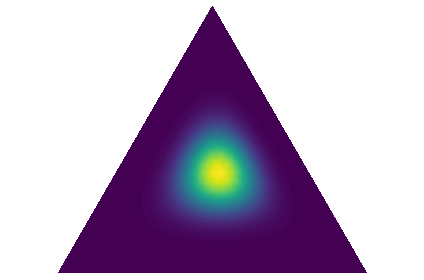

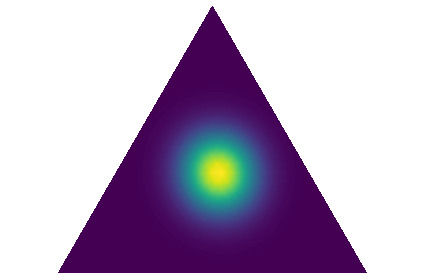

In [18]:
a = np.array([8, 9, 10])
#a = np.array([4,5,6])
#sample_dirichlet_contours(a)
#sample_sm_Normal_contours(np.array([-1, 2, -1]), 0.1*np.eye(3))
draw_pdf_contours(Dirichlet(a), filename='Dirichlet_pdf.png')

mu_test = dirichlet_mu(a)
Sigma_test = dirichlet_Sigma(a) + 1e-8*np.eye(len(a))
LA_Normal_contours(mu_test, Sigma_test, filename='Fake_softmax_Gaussian.png')

# this looks pretty good. Not sure wtf is going on with the KL divergence

# Compute KL divergence, Attempt 4

In [344]:
from scipy.stats import norm

def KL_div_samples_dirichlet4(a, num_samples, softmax=False, plot=False, eps=1e-8):
    
    dirichlet_samples = dirichlet.rvs(a, size=num_samples)
    num_bins = int(np.cbrt(num_samples)) #third root of num samples
    
    if softmax:
    
        #dir_samples_inv_sm = inverse_softmax_transform_all(dirichlet_samples)
        mu_dir_inv_sm = dirichlet_t_softmax_mu(a) 
        Sigma_dir_inv_sm = dirichlet_t_softmax_Sigma(a) + np.eye(3)*1e-8
        #print("Sigma_dir_inv_sm: ", Sigma_dir_inv_sm)
        
        s = np.array(dirichlet_samples)
        p_ = np.array([dirichlet.pdf(s_, a) for s_ in s])
        q_ = np.array([fake_inverse_softmax_Gaussian_pdf(y_, mu_dir_inv_sm, Sigma_dir_inv_sm) for y_ in s])
        p_ /= p_.mean()
        q_ /= q_.mean()
        KL_div_inv_sm_ = np.mean(np.log((p_/q_)))
            
        if plot:
            x_ = np.linspace(s[:,0].min(), s[:,0].max(), 1000+1)
            plt.hist(s[:,0], density=True, bins=num_bins)
            #q_pdf = np.array([fake_inverse_softmax_Gaussian_pdf(y_, mu_dir_inv_sm, Sigma_dir_inv_sm) for y_ in x_])
            plt.plot(x_, beta.pdf(x_, a[0], a[1:].sum()))
            #plt.plot(x_, q_pdf)
            plt.title('softmax-base marginal')
            plt.show();
        
        return(KL_div_inv_sm_)
    
    else:
    
        mu_dir = dirichlet_mu(a)
        Sigma_dir = dirichlet_Sigma(a)
        
        refiner = tri.UniformTriRefiner(triangle)
        trimesh = refiner.refine_triangulation(subdiv=5)
        xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])

        p_ = np.array([dirichlet_pdf(s_, a) for s_ in xys])
        q_ = np.array([mv_norm.pdf(s_, mu_dir, Sigma_dir) for s_ in xys])
        plt.plot(p_[-100:])
        plt.plot(q_[-100:])
        plt.show()
        KL_div_inv_sm_ = np.mean(p_ * np.log((p_)/(q_)))
            
        if plot:
            LA_Normal_contours(mu_dir, Sigma_dir)
        
        return(KL_div_inv_sm_)
        
        


In [345]:
def KL_div_samples_combinations4(params, num_samples, plot=False, verbose=True):
    
    As = params
    
    KL_div_sum = 0
    KL_div_sm_sum = 0

    for a in As:

        if verbose:
            print("a: ", a)

        if np.min(a) < 1: #if it contains a value smaller than 1
            print("a_i < 1: not legitimate in standard base")
            KL_div_ = np.nan
        else:
            KL_div_ = KL_div_samples_dirichlet4(a, num_samples=num_samples, plot=plot)

        #compute KL-div for logit base
        KL_div_sm_ = KL_div_samples_dirichlet4(a, num_samples=num_samples, softmax=True, plot=plot)
        KL_div_sm_sum += KL_div_sm_
        KL_div_sum += KL_div_

        if verbose:
            print("standard: ", KL_div_, "inverse softmax: ", KL_div_sm_)

            
    return(KL_div_sum, KL_div_sm_sum)

a:  [1.1 1.2 1.3]


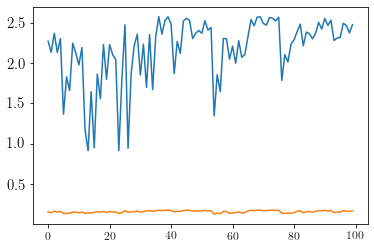

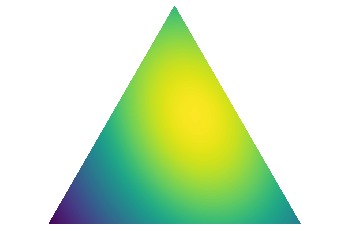

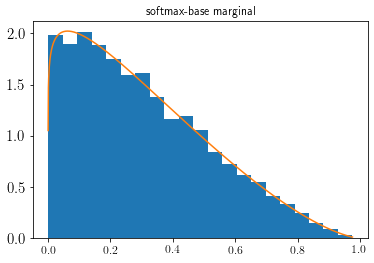

standard:  4.939217141039604 inverse softmax:  0.5120908308842083
a:  [2 2 3]


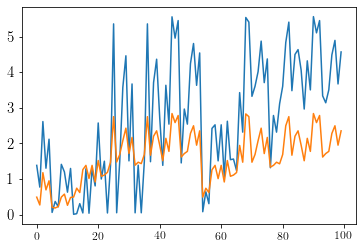

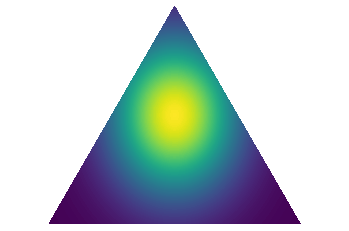

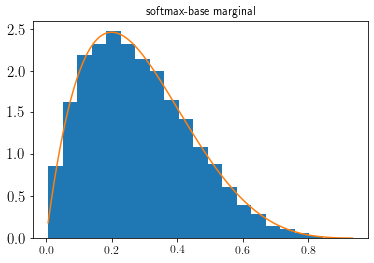

standard:  1.1028790451711223 inverse softmax:  0.2492462010370586
a:  [ 8  9 10]


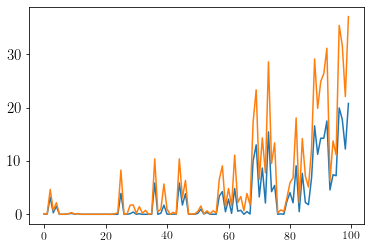

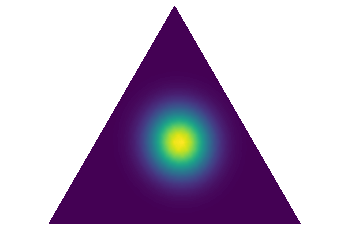

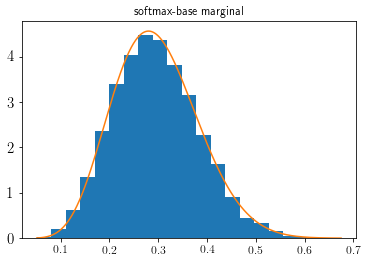

standard:  -1.1468127279138465 inverse softmax:  0.05910609820028295


(4.8952834582968805, 0.8204431301215498)

In [347]:
a_s = np.array([1.1, 1.2, 1.3])
a_m = np.array([2,2,3])
a_l = np.array([8,9,10])

test_As = [a_s, a_m, a_l]
#test_As = [a_m, a_l]
KL_div_samples_combinations4(test_As, num_samples=10000, verbose=True, plot=True)

# Statistical distance measures for small, medium and large $\theta$

In [26]:
a_s = np.array([1.1, 1.1, 1.1])
a_m = np.array([2,2,3])
a_l = np.array([8,9,10])

## calculate MMD for the three pairs of parameters

In [27]:
# use 10 seeds
MMD_results_s = []
MMD_results_m = []
MMD_results_l = []

for s in range(10):
    print("seed: ", s)
    np.random.seed(s)
    torch.manual_seed(s)
    MMD_s = MMD_combinations(params = [a_s], n_samples=2000)
    MMD_m = MMD_combinations(params = [a_m], n_samples=2000)
    MMD_l = MMD_combinations(params = [a_l], n_samples=2000)
    MMD_results_s += [MMD_s]
    MMD_results_m += [MMD_m]
    MMD_results_l += [MMD_l]
    
MMD_results_mean_s = np.array(MMD_results_s).mean(0)
MMD_results_mean_m = np.array(MMD_results_m).mean(0)
MMD_results_mean_l = np.array(MMD_results_l).mean(0)
print(MMD_results_mean_s)
print(MMD_results_mean_m)
print(MMD_results_mean_l)

seed:  0
a:  [1.1 1.1 1.1]
standard:  0.41055238246917725 softmax:  0.017788678407669067
a:  [2 2 3]
standard:  0.014296412467956543 softmax:  0.007753819227218628
a:  [ 8  9 10]
standard:  0.00016361474990844727 softmax:  0.0002256631851196289
seed:  1
a:  [1.1 1.1 1.1]
standard:  0.41200727224349976 softmax:  0.017946213483810425
a:  [2 2 3]
standard:  0.014420688152313232 softmax:  0.006688296794891357
a:  [ 8  9 10]
standard:  0.00038492679595947266 softmax:  0.00020843744277954102
seed:  2
a:  [1.1 1.1 1.1]
standard:  0.41212284564971924 softmax:  0.01704511046409607
a:  [2 2 3]
standard:  0.013623297214508057 softmax:  0.00837022066116333
a:  [ 8  9 10]
standard:  0.00024044513702392578 softmax:  4.291534423828125e-06
seed:  3
a:  [1.1 1.1 1.1]
standard:  0.4089811444282532 softmax:  0.018064767122268677
a:  [2 2 3]
standard:  0.014765381813049316 softmax:  0.005808383226394653
a:  [ 8  9 10]
standard:  0.00024694204330444336 softmax:  0.00015693902969360352
seed:  4
a:  [1.1 1.1

In [28]:
# normalize to 1 for comparison
#MMD_results_mean_s[0] = MMD_results_mean_s[1:].max()
MMD_results_mean_s_normalized = MMD_results_mean_s/MMD_results_mean_s.max()
#MMD_results_mean_s_normalized[0] = np.nan
print(MMD_results_mean_s_normalized)
print(MMD_results_mean_m/MMD_results_mean_m.max())
print(MMD_results_mean_l/MMD_results_mean_l.max())

[1.         0.04341122]
[1.        0.5218913]
[1.         0.88072836]


## calculate KL div for the three parameters

In [29]:
def KL_combinations(params, n_samples=10000, verbose=True):
    
    a = np.array(params).reshape(-1)

    mu = dirichlet_mu(a)
    Sigma = dirichlet_Sigma(a)

    D_samples = dirichlet.rvs(a, size=n_samples)
    N_samples = mv_norm.rvs(mu, Sigma, size=n_samples)
    
    KL_ = KL_divergence_samples(D_samples, N_samples, plot=False)
    
    ####softmax base
    mode1_softmax = dirichlet_t_softmax_mu(a)
    Sigma1_softmax = dirichlet_t_softmax_Sigma(a)
    D_samples_softmax = inverse_softmax_transform(D_samples)
    N_samples_softmax = mv_norm.rvs(mode1_softmax, Sigma1_softmax, size=n_samples)
    
    KL_softmax_ = KL_divergence_samples(D_samples_softmax, N_samples_softmax, plot=False)
    
    if verbose: 
            print("standard: ", KL_.item(), "softmax: ", KL_softmax_.item())
            
    return([KL_, KL_softmax_])

In [30]:
# use 10 seeds
KL_results_s = []
KL_results_m = []
KL_results_l = []

for s in range(10):
    print("seed: ", s)
    np.random.seed(s)
    torch.manual_seed(s)    
    KL_s = KL_combinations(params = [a_s], n_samples=100000)
    KL_m = KL_combinations(params = [a_m], n_samples=100000)
    KL_l = KL_combinations(params = [a_l], n_samples=100000)
    KL_results_s += [KL_s]
    KL_results_m += [KL_m]
    KL_results_l += [KL_l]
    
KL_results_mean_s = np.array(KL_results_s).mean(0)
KL_results_mean_m = np.array(KL_results_m).mean(0)
KL_results_mean_l = np.array(KL_results_l).mean(0)
print(KL_results_mean_s)
print(KL_results_mean_m)
print(KL_results_mean_l)

seed:  0


NameError: name 'KL_divergence_samples' is not defined

In [ ]:
# normalize to 1 for comparison
#KL_results_mean_s[0] = KL_results_mean_s[1:].max()
KL_results_mean_s_normalized = KL_results_mean_s/KL_results_mean_s.max()
#KL_results_mean_s_normalized[0] = np.nan
print(KL_results_mean_s_normalized)
print(KL_results_mean_m/KL_results_mean_m.max())
print(KL_results_mean_l/KL_results_mean_l.max())

# Calculate KL-divergence for growing a_i and plot it

In [368]:
a_0 = np.array([0.8, 0.8, 0.8])
multiplier = np.array([1.5, 1, 0.75])
As = np.array([np.array(a_0 * multiplier * i) for i in range(1,11)])
print(As)

[[ 1.2  0.8  0.6]
 [ 2.4  1.6  1.2]
 [ 3.6  2.4  1.8]
 [ 4.8  3.2  2.4]
 [ 6.   4.   3. ]
 [ 7.2  4.8  3.6]
 [ 8.4  5.6  4.2]
 [ 9.6  6.4  4.8]
 [10.8  7.2  5.4]
 [12.   8.   6. ]]


seed:  0
[1.2 0.8 0.6]
a:  [1.2 0.8 0.6]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  0.4324054926183864
(nan, 0.4324054926183864)
[2.4 1.6 1.2]
a:  [2.4 1.6 1.2]
[0.63636364 0.27272727 0.09090909] [0.63636364 0.27272727 0.09090909]
[[0.2892562  0.         0.        ]
 [0.         0.12396694 0.        ]
 [0.         0.         0.04132231]]


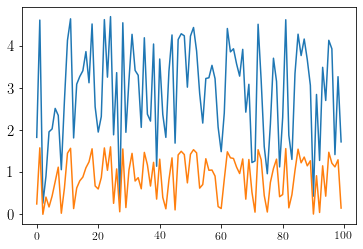

standard:  1.3257425393874822 inverse softmax:  0.38455387078326747
(1.3257425393874822, 0.38455387078326747)
[3.6 2.4 1.8]
a:  [3.6 2.4 1.8]
[0.54166667 0.29166667 0.16666667] [0.54166667 0.29166667 0.16666667]
[[0.11284722 0.         0.        ]
 [0.         0.06076389 0.        ]
 [0.         0.         0.03472222]]


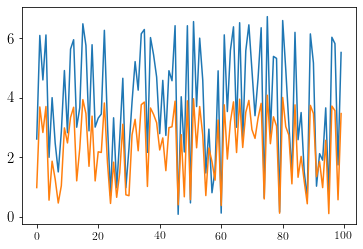

standard:  0.5051690984471836 inverse softmax:  0.2535293269770537
(0.5051690984471836, 0.2535293269770537)
[4.8 3.2 2.4]
a:  [4.8 3.2 2.4]
[0.51351351 0.2972973  0.18918919] [0.51351351 0.2972973  0.18918919]
[[0.06939372 0.         0.        ]
 [0.         0.04017531 0.        ]
 [0.         0.         0.02556611]]


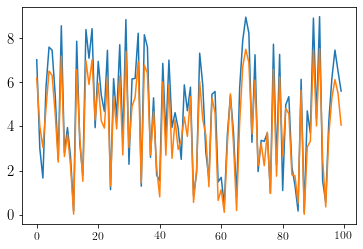

standard:  0.14981677804080892 inverse softmax:  0.19341106743879322
(0.14981677804080892, 0.19341106743879322)
[6. 4. 3.]
a:  [6. 4. 3.]
[0.5 0.3 0.2] [0.5 0.3 0.2]
[[0.05 0.   0.  ]
 [0.   0.03 0.  ]
 [0.   0.   0.02]]


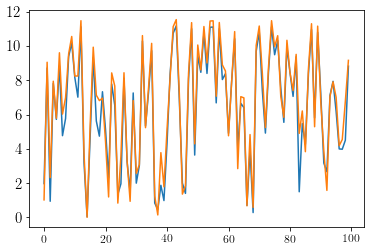

standard:  -0.06051008995043809 inverse softmax:  0.15162316891104946
(-0.06051008995043809, 0.15162316891104946)
[7.2 4.8 3.6]
a:  [7.2 4.8 3.6]
[0.49206349 0.3015873  0.20634921] [0.49206349 0.3015873  0.20634921]
[[0.03905266 0.         0.        ]
 [0.         0.0239355  0.        ]
 [0.         0.         0.01637692]]


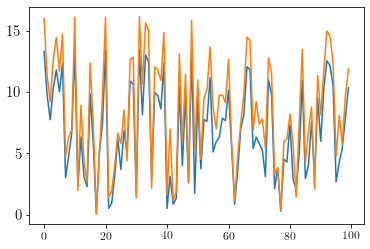

standard:  -0.2203652901939363 inverse softmax:  0.12686925386754433
(-0.2203652901939363, 0.12686925386754433)
[8.4 5.6 4.2]
a:  [8.4 5.6 4.2]
[0.48684211 0.30263158 0.21052632] [0.48684211 0.30263158 0.21052632]
[[0.03202909 0.         0.        ]
 [0.         0.01990997 0.        ]
 [0.         0.         0.01385042]]


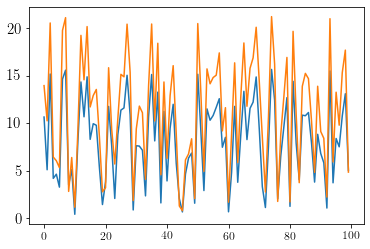

standard:  -0.3363855619317925 inverse softmax:  0.11708543928967599
(-0.3363855619317925, 0.11708543928967599)
[9.6 6.4 4.8]
a:  [9.6 6.4 4.8]
[0.48314607 0.30337079 0.21348315] [0.48314607 0.30337079 0.21348315]
[[0.02714304 0.         0.        ]
 [0.         0.0170433  0.        ]
 [0.         0.         0.01199344]]


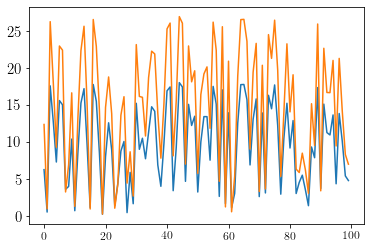

standard:  -0.4328310331649551 inverse softmax:  0.09716068212031366
(-0.4328310331649551, 0.09716068212031366)
[10.8  7.2  5.4]
a:  [10.8  7.2  5.4]
[0.48039216 0.30392157 0.21568627] [0.48039216 0.30392157 0.21568627]
[[0.02354864 0.         0.        ]
 [0.         0.01489812 0.        ]
 [0.         0.         0.01057286]]


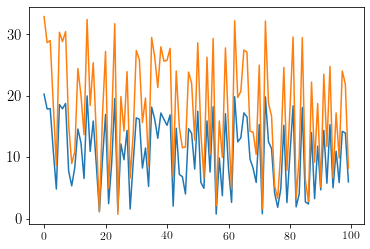

standard:  -0.5120828841113686 inverse softmax:  0.08180487976904714
(-0.5120828841113686, 0.08180487976904714)
[12.  8.  6.]
a:  [12.  8.  6.]
[0.47826087 0.30434783 0.2173913 ] [0.47826087 0.30434783 0.2173913 ]
[[0.02079395 0.         0.        ]
 [0.         0.01323251 0.        ]
 [0.         0.         0.0094518 ]]


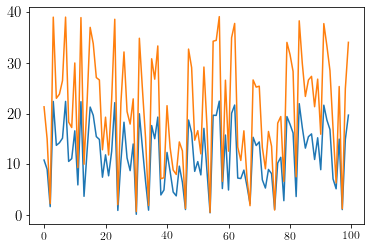

standard:  -0.5786125447787678 inverse softmax:  0.07524724612421912
(-0.5786125447787678, 0.07524724612421912)
seed:  1
[1.2 0.8 0.6]
a:  [1.2 0.8 0.6]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  0.4353402222882939
(nan, 0.4353402222882939)
[2.4 1.6 1.2]
a:  [2.4 1.6 1.2]
[0.63636364 0.27272727 0.09090909] [0.63636364 0.27272727 0.09090909]
[[0.2892562  0.         0.        ]
 [0.         0.12396694 0.        ]
 [0.         0.         0.04132231]]


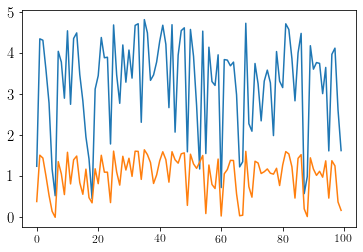

standard:  1.3295277965880632 inverse softmax:  0.4002185612592996
(1.3295277965880632, 0.4002185612592996)
[3.6 2.4 1.8]
a:  [3.6 2.4 1.8]
[0.54166667 0.29166667 0.16666667] [0.54166667 0.29166667 0.16666667]
[[0.11284722 0.         0.        ]
 [0.         0.06076389 0.        ]
 [0.         0.         0.03472222]]


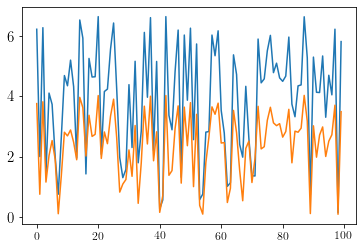

standard:  0.511626235122172 inverse softmax:  0.2946721544594666
(0.511626235122172, 0.2946721544594666)
[4.8 3.2 2.4]
a:  [4.8 3.2 2.4]
[0.51351351 0.2972973  0.18918919] [0.51351351 0.2972973  0.18918919]
[[0.06939372 0.         0.        ]
 [0.         0.04017531 0.        ]
 [0.         0.         0.02556611]]


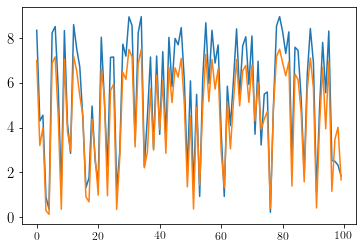

standard:  0.15534932245321867 inverse softmax:  0.20345456209828136
(0.15534932245321867, 0.20345456209828136)
[6. 4. 3.]
a:  [6. 4. 3.]
[0.5 0.3 0.2] [0.5 0.3 0.2]
[[0.05 0.   0.  ]
 [0.   0.03 0.  ]
 [0.   0.   0.02]]


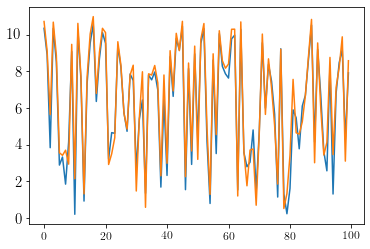

standard:  -0.06950673108446334 inverse softmax:  0.1499185240937319
(-0.06950673108446334, 0.1499185240937319)
[7.2 4.8 3.6]
a:  [7.2 4.8 3.6]
[0.49206349 0.3015873  0.20634921] [0.49206349 0.3015873  0.20634921]
[[0.03905266 0.         0.        ]
 [0.         0.0239355  0.        ]
 [0.         0.         0.01637692]]


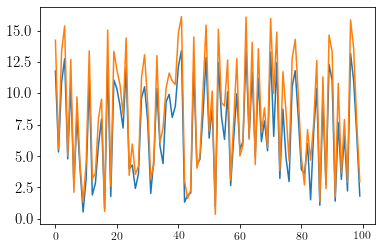

standard:  -0.2140849549063324 inverse softmax:  0.12405180544065993
(-0.2140849549063324, 0.12405180544065993)
[8.4 5.6 4.2]
a:  [8.4 5.6 4.2]
[0.48684211 0.30263158 0.21052632] [0.48684211 0.30263158 0.21052632]
[[0.03202909 0.         0.        ]
 [0.         0.01990997 0.        ]
 [0.         0.         0.01385042]]


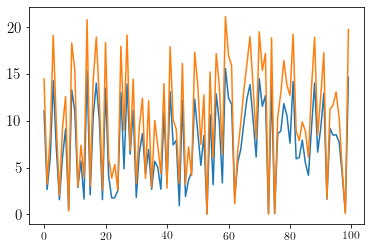

standard:  -0.3375451476383374 inverse softmax:  0.1084879844351902
(-0.3375451476383374, 0.1084879844351902)
[9.6 6.4 4.8]
a:  [9.6 6.4 4.8]
[0.48314607 0.30337079 0.21348315] [0.48314607 0.30337079 0.21348315]
[[0.02714304 0.         0.        ]
 [0.         0.0170433  0.        ]
 [0.         0.         0.01199344]]


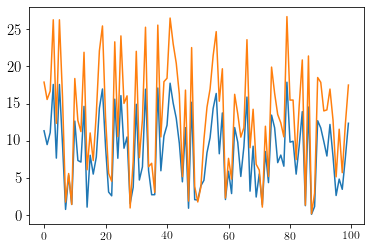

standard:  -0.4306408909365212 inverse softmax:  0.10303385099766772
(-0.4306408909365212, 0.10303385099766772)
[10.8  7.2  5.4]
a:  [10.8  7.2  5.4]
[0.48039216 0.30392157 0.21568627] [0.48039216 0.30392157 0.21568627]
[[0.02354864 0.         0.        ]
 [0.         0.01489812 0.        ]
 [0.         0.         0.01057286]]


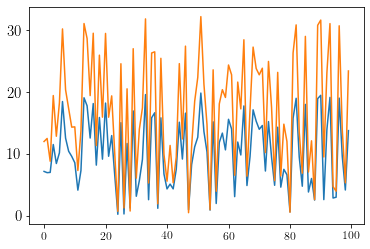

standard:  -0.5113814994299886 inverse softmax:  0.08676758543874624
(-0.5113814994299886, 0.08676758543874624)
[12.  8.  6.]
a:  [12.  8.  6.]
[0.47826087 0.30434783 0.2173913 ] [0.47826087 0.30434783 0.2173913 ]
[[0.02079395 0.         0.        ]
 [0.         0.01323251 0.        ]
 [0.         0.         0.0094518 ]]


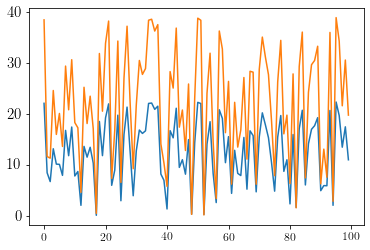

standard:  -0.586538625413434 inverse softmax:  0.0703959800706058
(-0.586538625413434, 0.0703959800706058)
seed:  2
[1.2 0.8 0.6]
a:  [1.2 0.8 0.6]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  0.417744170604876
(nan, 0.417744170604876)
[2.4 1.6 1.2]
a:  [2.4 1.6 1.2]
[0.63636364 0.27272727 0.09090909] [0.63636364 0.27272727 0.09090909]
[[0.2892562  0.         0.        ]
 [0.         0.12396694 0.        ]
 [0.         0.         0.04132231]]


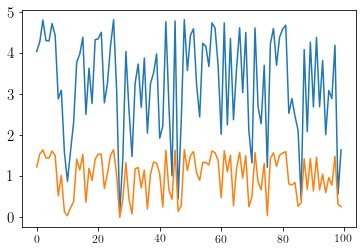

standard:  1.323767950660312 inverse softmax:  0.3901990181978945
(1.323767950660312, 0.3901990181978945)
[3.6 2.4 1.8]
a:  [3.6 2.4 1.8]
[0.54166667 0.29166667 0.16666667] [0.54166667 0.29166667 0.16666667]
[[0.11284722 0.         0.        ]
 [0.         0.06076389 0.        ]
 [0.         0.         0.03472222]]


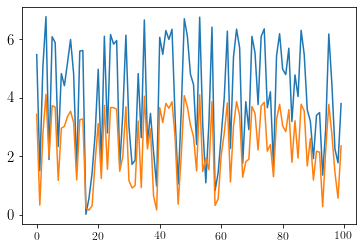

standard:  0.49938534848624383 inverse softmax:  0.26201307902737664
(0.49938534848624383, 0.26201307902737664)
[4.8 3.2 2.4]
a:  [4.8 3.2 2.4]
[0.51351351 0.2972973  0.18918919] [0.51351351 0.2972973  0.18918919]
[[0.06939372 0.         0.        ]
 [0.         0.04017531 0.        ]
 [0.         0.         0.02556611]]


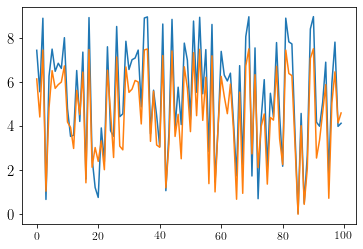

standard:  0.15593361077554674 inverse softmax:  0.19132355482863111
(0.15593361077554674, 0.19132355482863111)
[6. 4. 3.]
a:  [6. 4. 3.]
[0.5 0.3 0.2] [0.5 0.3 0.2]
[[0.05 0.   0.  ]
 [0.   0.03 0.  ]
 [0.   0.   0.02]]


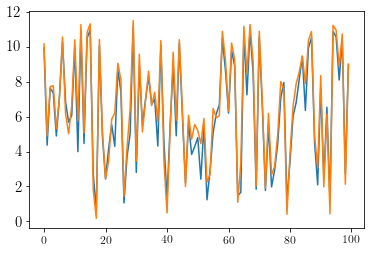

standard:  -0.06373522652560525 inverse softmax:  0.1444720678395017
(-0.06373522652560525, 0.1444720678395017)
[7.2 4.8 3.6]
a:  [7.2 4.8 3.6]
[0.49206349 0.3015873  0.20634921] [0.49206349 0.3015873  0.20634921]
[[0.03905266 0.         0.        ]
 [0.         0.0239355  0.        ]
 [0.         0.         0.01637692]]


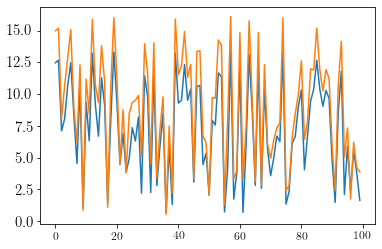

standard:  -0.21373751627546764 inverse softmax:  0.1424469441418188
(-0.21373751627546764, 0.1424469441418188)
[8.4 5.6 4.2]
a:  [8.4 5.6 4.2]
[0.48684211 0.30263158 0.21052632] [0.48684211 0.30263158 0.21052632]
[[0.03202909 0.         0.        ]
 [0.         0.01990997 0.        ]
 [0.         0.         0.01385042]]


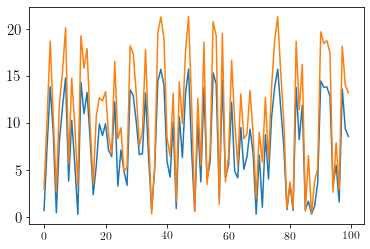

standard:  -0.3326896661070865 inverse softmax:  0.11403073255611339
(-0.3326896661070865, 0.11403073255611339)
[9.6 6.4 4.8]
a:  [9.6 6.4 4.8]
[0.48314607 0.30337079 0.21348315] [0.48314607 0.30337079 0.21348315]
[[0.02714304 0.         0.        ]
 [0.         0.0170433  0.        ]
 [0.         0.         0.01199344]]


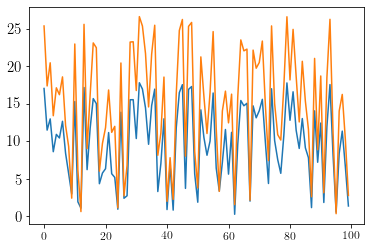

standard:  -0.42976543900547237 inverse softmax:  0.10278538682124531
(-0.42976543900547237, 0.10278538682124531)
[10.8  7.2  5.4]
a:  [10.8  7.2  5.4]
[0.48039216 0.30392157 0.21568627] [0.48039216 0.30392157 0.21568627]
[[0.02354864 0.         0.        ]
 [0.         0.01489812 0.        ]
 [0.         0.         0.01057286]]


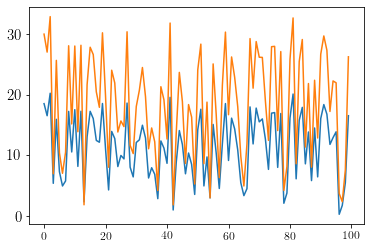

standard:  -0.5148558545039686 inverse softmax:  0.08947918837681229
(-0.5148558545039686, 0.08947918837681229)
[12.  8.  6.]
a:  [12.  8.  6.]
[0.47826087 0.30434783 0.2173913 ] [0.47826087 0.30434783 0.2173913 ]
[[0.02079395 0.         0.        ]
 [0.         0.01323251 0.        ]
 [0.         0.         0.0094518 ]]


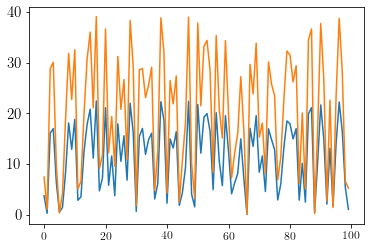

standard:  -0.5799342548159 inverse softmax:  0.07617807316135244
(-0.5799342548159, 0.07617807316135244)
seed:  3
[1.2 0.8 0.6]
a:  [1.2 0.8 0.6]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  0.38176318721142927
(nan, 0.38176318721142927)
[2.4 1.6 1.2]
a:  [2.4 1.6 1.2]
[0.63636364 0.27272727 0.09090909] [0.63636364 0.27272727 0.09090909]
[[0.2892562  0.         0.        ]
 [0.         0.12396694 0.        ]
 [0.         0.         0.04132231]]


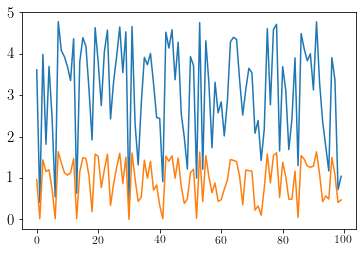

standard:  1.332954494717294 inverse softmax:  0.4012052133998111
(1.332954494717294, 0.4012052133998111)
[3.6 2.4 1.8]
a:  [3.6 2.4 1.8]
[0.54166667 0.29166667 0.16666667] [0.54166667 0.29166667 0.16666667]
[[0.11284722 0.         0.        ]
 [0.         0.06076389 0.        ]
 [0.         0.         0.03472222]]


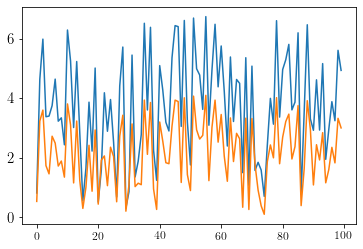

standard:  0.5035230342882859 inverse softmax:  0.2690291837287439
(0.5035230342882859, 0.2690291837287439)
[4.8 3.2 2.4]
a:  [4.8 3.2 2.4]
[0.51351351 0.2972973  0.18918919] [0.51351351 0.2972973  0.18918919]
[[0.06939372 0.         0.        ]
 [0.         0.04017531 0.        ]
 [0.         0.         0.02556611]]


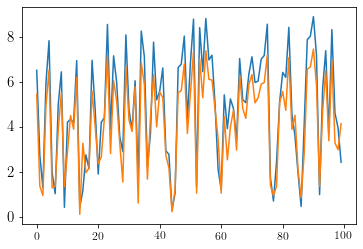

standard:  0.1536919940156926 inverse softmax:  0.2080400963989485
(0.1536919940156926, 0.2080400963989485)
[6. 4. 3.]
a:  [6. 4. 3.]
[0.5 0.3 0.2] [0.5 0.3 0.2]
[[0.05 0.   0.  ]
 [0.   0.03 0.  ]
 [0.   0.   0.02]]


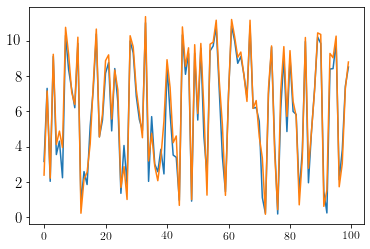

standard:  -0.06079236493651888 inverse softmax:  0.1634586884094341
(-0.06079236493651888, 0.1634586884094341)
[7.2 4.8 3.6]
a:  [7.2 4.8 3.6]
[0.49206349 0.3015873  0.20634921] [0.49206349 0.3015873  0.20634921]
[[0.03905266 0.         0.        ]
 [0.         0.0239355  0.        ]
 [0.         0.         0.01637692]]


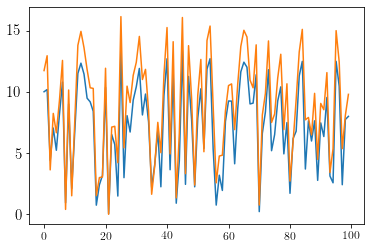

standard:  -0.22138204159114466 inverse softmax:  0.12985725350958618
(-0.22138204159114466, 0.12985725350958618)
[8.4 5.6 4.2]
a:  [8.4 5.6 4.2]
[0.48684211 0.30263158 0.21052632] [0.48684211 0.30263158 0.21052632]
[[0.03202909 0.         0.        ]
 [0.         0.01990997 0.        ]
 [0.         0.         0.01385042]]


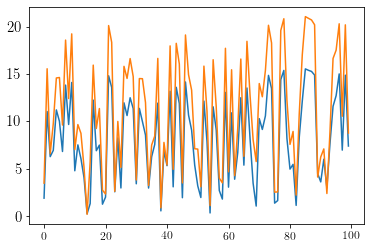

standard:  -0.3362320575532465 inverse softmax:  0.10880633336043313
(-0.3362320575532465, 0.10880633336043313)
[9.6 6.4 4.8]
a:  [9.6 6.4 4.8]
[0.48314607 0.30337079 0.21348315] [0.48314607 0.30337079 0.21348315]
[[0.02714304 0.         0.        ]
 [0.         0.0170433  0.        ]
 [0.         0.         0.01199344]]


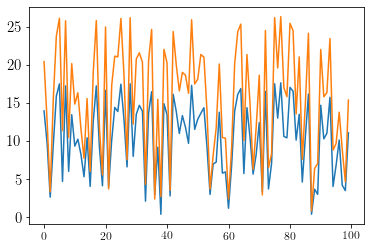

standard:  -0.4350291864913676 inverse softmax:  0.09091652834589618
(-0.4350291864913676, 0.09091652834589618)
[10.8  7.2  5.4]
a:  [10.8  7.2  5.4]
[0.48039216 0.30392157 0.21568627] [0.48039216 0.30392157 0.21568627]
[[0.02354864 0.         0.        ]
 [0.         0.01489812 0.        ]
 [0.         0.         0.01057286]]


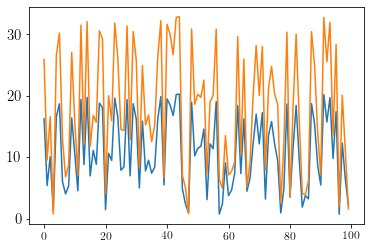

standard:  -0.5122925841380883 inverse softmax:  0.08049245995369092
(-0.5122925841380883, 0.08049245995369092)
[12.  8.  6.]
a:  [12.  8.  6.]
[0.47826087 0.30434783 0.2173913 ] [0.47826087 0.30434783 0.2173913 ]
[[0.02079395 0.         0.        ]
 [0.         0.01323251 0.        ]
 [0.         0.         0.0094518 ]]


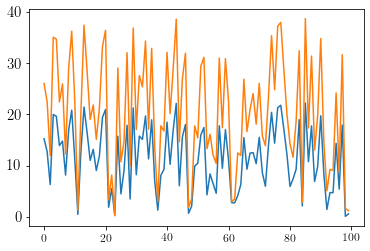

standard:  -0.5841980000554835 inverse softmax:  0.06859641028541624
(-0.5841980000554835, 0.06859641028541624)
seed:  4
[1.2 0.8 0.6]
a:  [1.2 0.8 0.6]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  0.43989833196692163
(nan, 0.43989833196692163)
[2.4 1.6 1.2]
a:  [2.4 1.6 1.2]
[0.63636364 0.27272727 0.09090909] [0.63636364 0.27272727 0.09090909]
[[0.2892562  0.         0.        ]
 [0.         0.12396694 0.        ]
 [0.         0.         0.04132231]]


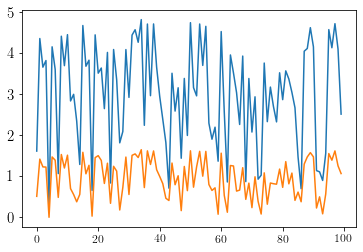

standard:  1.3383090348061277 inverse softmax:  0.4372150314576521
(1.3383090348061277, 0.4372150314576521)
[3.6 2.4 1.8]
a:  [3.6 2.4 1.8]
[0.54166667 0.29166667 0.16666667] [0.54166667 0.29166667 0.16666667]
[[0.11284722 0.         0.        ]
 [0.         0.06076389 0.        ]
 [0.         0.         0.03472222]]


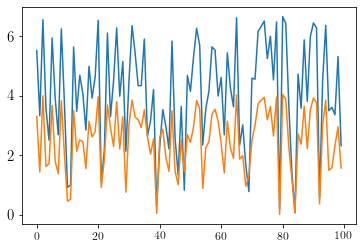

standard:  0.4994879286186093 inverse softmax:  0.27888099563275137
(0.4994879286186093, 0.27888099563275137)
[4.8 3.2 2.4]
a:  [4.8 3.2 2.4]
[0.51351351 0.2972973  0.18918919] [0.51351351 0.2972973  0.18918919]
[[0.06939372 0.         0.        ]
 [0.         0.04017531 0.        ]
 [0.         0.         0.02556611]]


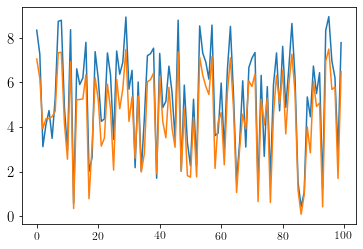

standard:  0.15391054624478961 inverse softmax:  0.19700075779707998
(0.15391054624478961, 0.19700075779707998)
[6. 4. 3.]
a:  [6. 4. 3.]
[0.5 0.3 0.2] [0.5 0.3 0.2]
[[0.05 0.   0.  ]
 [0.   0.03 0.  ]
 [0.   0.   0.02]]


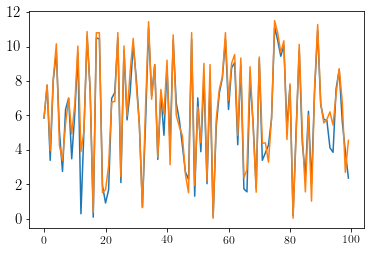

standard:  -0.06108759048461126 inverse softmax:  0.14536051399389352
(-0.06108759048461126, 0.14536051399389352)
[7.2 4.8 3.6]
a:  [7.2 4.8 3.6]
[0.49206349 0.3015873  0.20634921] [0.49206349 0.3015873  0.20634921]
[[0.03905266 0.         0.        ]
 [0.         0.0239355  0.        ]
 [0.         0.         0.01637692]]


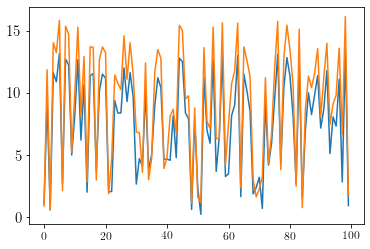

standard:  -0.21445344710362724 inverse softmax:  0.12847983566205273
(-0.21445344710362724, 0.12847983566205273)
[8.4 5.6 4.2]
a:  [8.4 5.6 4.2]
[0.48684211 0.30263158 0.21052632] [0.48684211 0.30263158 0.21052632]
[[0.03202909 0.         0.        ]
 [0.         0.01990997 0.        ]
 [0.         0.         0.01385042]]


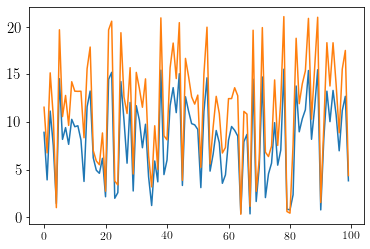

standard:  -0.3403570912680909 inverse softmax:  0.10715169001732429
(-0.3403570912680909, 0.10715169001732429)
[9.6 6.4 4.8]
a:  [9.6 6.4 4.8]
[0.48314607 0.30337079 0.21348315] [0.48314607 0.30337079 0.21348315]
[[0.02714304 0.         0.        ]
 [0.         0.0170433  0.        ]
 [0.         0.         0.01199344]]


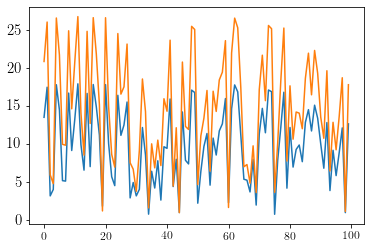

standard:  -0.43245248587928226 inverse softmax:  0.10045474825701778
(-0.43245248587928226, 0.10045474825701778)
[10.8  7.2  5.4]
a:  [10.8  7.2  5.4]
[0.48039216 0.30392157 0.21568627] [0.48039216 0.30392157 0.21568627]
[[0.02354864 0.         0.        ]
 [0.         0.01489812 0.        ]
 [0.         0.         0.01057286]]


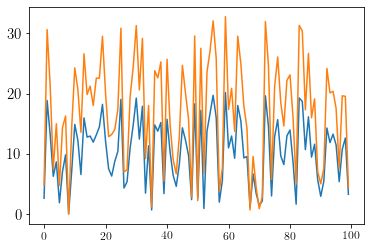

standard:  -0.5090709036116989 inverse softmax:  0.08585724799442503
(-0.5090709036116989, 0.08585724799442503)
[12.  8.  6.]
a:  [12.  8.  6.]
[0.47826087 0.30434783 0.2173913 ] [0.47826087 0.30434783 0.2173913 ]
[[0.02079395 0.         0.        ]
 [0.         0.01323251 0.        ]
 [0.         0.         0.0094518 ]]


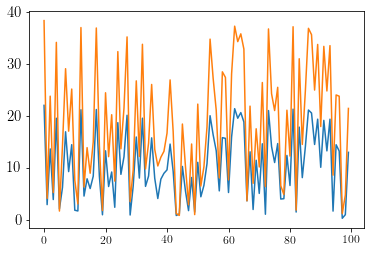

standard:  -0.5835005382504647 inverse softmax:  0.07422139695498318
(-0.5835005382504647, 0.07422139695498318)
seed:  5
[1.2 0.8 0.6]
a:  [1.2 0.8 0.6]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  0.22830510108844795
(nan, 0.22830510108844795)
[2.4 1.6 1.2]
a:  [2.4 1.6 1.2]
[0.63636364 0.27272727 0.09090909] [0.63636364 0.27272727 0.09090909]
[[0.2892562  0.         0.        ]
 [0.         0.12396694 0.        ]
 [0.         0.         0.04132231]]


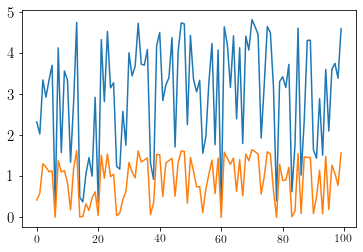

standard:  1.33414495346965 inverse softmax:  0.39445693129755843
(1.33414495346965, 0.39445693129755843)
[3.6 2.4 1.8]
a:  [3.6 2.4 1.8]
[0.54166667 0.29166667 0.16666667] [0.54166667 0.29166667 0.16666667]
[[0.11284722 0.         0.        ]
 [0.         0.06076389 0.        ]
 [0.         0.         0.03472222]]


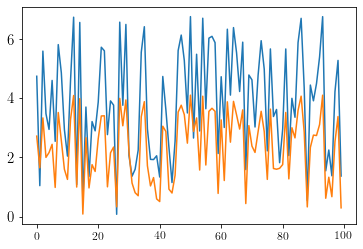

standard:  0.5038249500050309 inverse softmax:  0.28316778844785734
(0.5038249500050309, 0.28316778844785734)
[4.8 3.2 2.4]
a:  [4.8 3.2 2.4]
[0.51351351 0.2972973  0.18918919] [0.51351351 0.2972973  0.18918919]
[[0.06939372 0.         0.        ]
 [0.         0.04017531 0.        ]
 [0.         0.         0.02556611]]


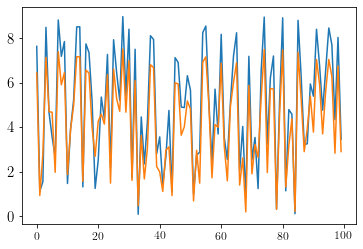

standard:  0.15536466545297112 inverse softmax:  0.19672966101787237
(0.15536466545297112, 0.19672966101787237)
[6. 4. 3.]
a:  [6. 4. 3.]
[0.5 0.3 0.2] [0.5 0.3 0.2]
[[0.05 0.   0.  ]
 [0.   0.03 0.  ]
 [0.   0.   0.02]]


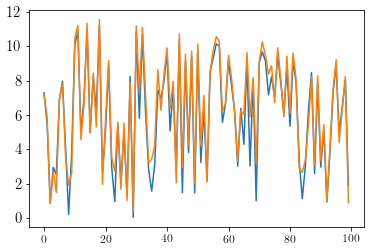

standard:  -0.06534821075647251 inverse softmax:  0.16311179596094544
(-0.06534821075647251, 0.16311179596094544)
[7.2 4.8 3.6]
a:  [7.2 4.8 3.6]
[0.49206349 0.3015873  0.20634921] [0.49206349 0.3015873  0.20634921]
[[0.03905266 0.         0.        ]
 [0.         0.0239355  0.        ]
 [0.         0.         0.01637692]]


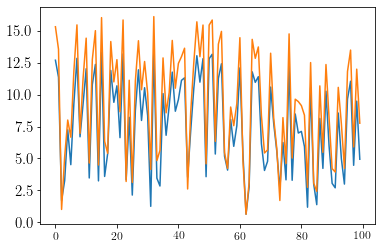

standard:  -0.21810744069668545 inverse softmax:  0.12650974127175155
(-0.21810744069668545, 0.12650974127175155)
[8.4 5.6 4.2]
a:  [8.4 5.6 4.2]
[0.48684211 0.30263158 0.21052632] [0.48684211 0.30263158 0.21052632]
[[0.03202909 0.         0.        ]
 [0.         0.01990997 0.        ]
 [0.         0.         0.01385042]]


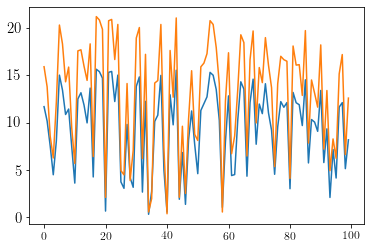

standard:  -0.33535794515447964 inverse softmax:  0.10727411826159107
(-0.33535794515447964, 0.10727411826159107)
[9.6 6.4 4.8]
a:  [9.6 6.4 4.8]
[0.48314607 0.30337079 0.21348315] [0.48314607 0.30337079 0.21348315]
[[0.02714304 0.         0.        ]
 [0.         0.0170433  0.        ]
 [0.         0.         0.01199344]]


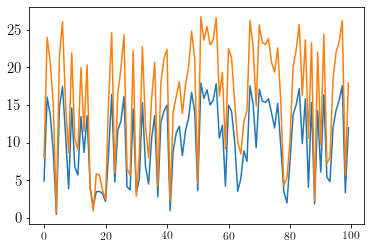

standard:  -0.4285928234713663 inverse softmax:  0.09546403989683747
(-0.4285928234713663, 0.09546403989683747)
[10.8  7.2  5.4]
a:  [10.8  7.2  5.4]
[0.48039216 0.30392157 0.21568627] [0.48039216 0.30392157 0.21568627]
[[0.02354864 0.         0.        ]
 [0.         0.01489812 0.        ]
 [0.         0.         0.01057286]]


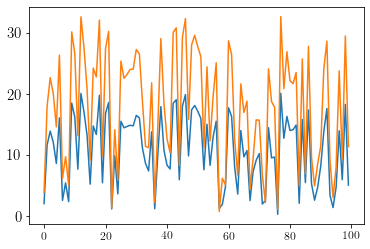

standard:  -0.5121257756314348 inverse softmax:  0.07737780441575294
(-0.5121257756314348, 0.07737780441575294)
[12.  8.  6.]
a:  [12.  8.  6.]
[0.47826087 0.30434783 0.2173913 ] [0.47826087 0.30434783 0.2173913 ]
[[0.02079395 0.         0.        ]
 [0.         0.01323251 0.        ]
 [0.         0.         0.0094518 ]]


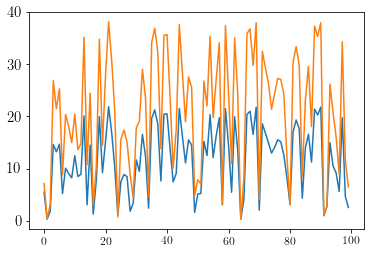

standard:  -0.5820986138388348 inverse softmax:  0.07494992897994768
(-0.5820986138388348, 0.07494992897994768)
seed:  6
[1.2 0.8 0.6]
a:  [1.2 0.8 0.6]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  0.3886256026057287
(nan, 0.3886256026057287)
[2.4 1.6 1.2]
a:  [2.4 1.6 1.2]
[0.63636364 0.27272727 0.09090909] [0.63636364 0.27272727 0.09090909]
[[0.2892562  0.         0.        ]
 [0.         0.12396694 0.        ]
 [0.         0.         0.04132231]]


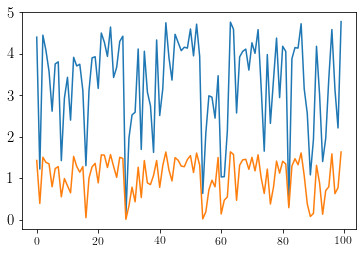

standard:  1.3378317619009907 inverse softmax:  0.38985273564525424
(1.3378317619009907, 0.38985273564525424)
[3.6 2.4 1.8]
a:  [3.6 2.4 1.8]
[0.54166667 0.29166667 0.16666667] [0.54166667 0.29166667 0.16666667]
[[0.11284722 0.         0.        ]
 [0.         0.06076389 0.        ]
 [0.         0.         0.03472222]]


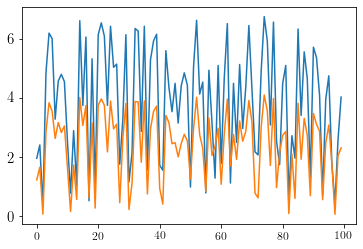

standard:  0.5086271385071962 inverse softmax:  0.26338814830223134
(0.5086271385071962, 0.26338814830223134)
[4.8 3.2 2.4]
a:  [4.8 3.2 2.4]
[0.51351351 0.2972973  0.18918919] [0.51351351 0.2972973  0.18918919]
[[0.06939372 0.         0.        ]
 [0.         0.04017531 0.        ]
 [0.         0.         0.02556611]]


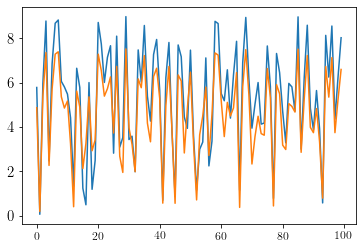

standard:  0.15577539211567012 inverse softmax:  0.2042324059980977
(0.15577539211567012, 0.2042324059980977)
[6. 4. 3.]
a:  [6. 4. 3.]
[0.5 0.3 0.2] [0.5 0.3 0.2]
[[0.05 0.   0.  ]
 [0.   0.03 0.  ]
 [0.   0.   0.02]]


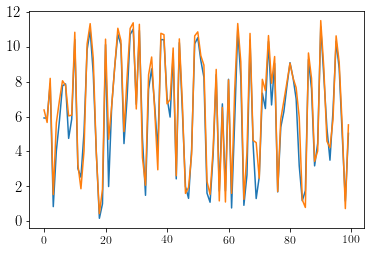

standard:  -0.06366962014270006 inverse softmax:  0.15774352117120732
(-0.06366962014270006, 0.15774352117120732)
[7.2 4.8 3.6]
a:  [7.2 4.8 3.6]
[0.49206349 0.3015873  0.20634921] [0.49206349 0.3015873  0.20634921]
[[0.03905266 0.         0.        ]
 [0.         0.0239355  0.        ]
 [0.         0.         0.01637692]]


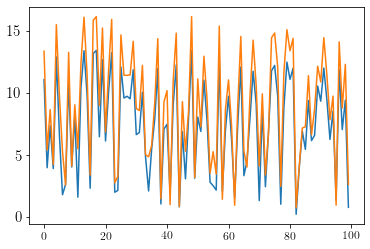

standard:  -0.22123686868455916 inverse softmax:  0.12701329127124883
(-0.22123686868455916, 0.12701329127124883)
[8.4 5.6 4.2]
a:  [8.4 5.6 4.2]
[0.48684211 0.30263158 0.21052632] [0.48684211 0.30263158 0.21052632]
[[0.03202909 0.         0.        ]
 [0.         0.01990997 0.        ]
 [0.         0.         0.01385042]]


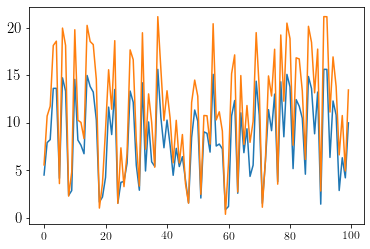

standard:  -0.33634591171016726 inverse softmax:  0.10497876216932359
(-0.33634591171016726, 0.10497876216932359)
[9.6 6.4 4.8]
a:  [9.6 6.4 4.8]
[0.48314607 0.30337079 0.21348315] [0.48314607 0.30337079 0.21348315]
[[0.02714304 0.         0.        ]
 [0.         0.0170433  0.        ]
 [0.         0.         0.01199344]]


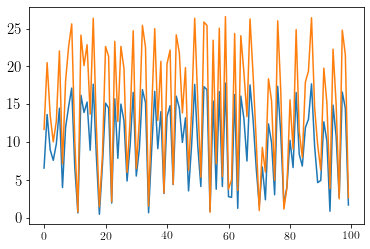

standard:  -0.43533453556464874 inverse softmax:  0.10304179304156005
(-0.43533453556464874, 0.10304179304156005)
[10.8  7.2  5.4]
a:  [10.8  7.2  5.4]
[0.48039216 0.30392157 0.21568627] [0.48039216 0.30392157 0.21568627]
[[0.02354864 0.         0.        ]
 [0.         0.01489812 0.        ]
 [0.         0.         0.01057286]]


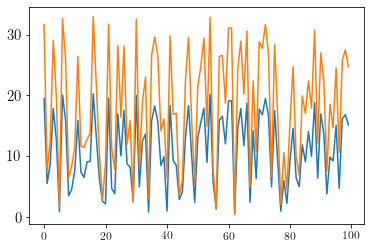

standard:  -0.5110342539820516 inverse softmax:  0.09345076299361019
(-0.5110342539820516, 0.09345076299361019)
[12.  8.  6.]
a:  [12.  8.  6.]
[0.47826087 0.30434783 0.2173913 ] [0.47826087 0.30434783 0.2173913 ]
[[0.02079395 0.         0.        ]
 [0.         0.01323251 0.        ]
 [0.         0.         0.0094518 ]]


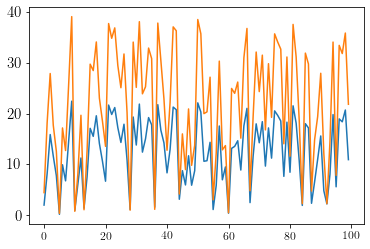

standard:  -0.5845098133797206 inverse softmax:  0.07006954274519067
(-0.5845098133797206, 0.07006954274519067)
seed:  7
[1.2 0.8 0.6]
a:  [1.2 0.8 0.6]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  0.36007779831340664
(nan, 0.36007779831340664)
[2.4 1.6 1.2]
a:  [2.4 1.6 1.2]
[0.63636364 0.27272727 0.09090909] [0.63636364 0.27272727 0.09090909]
[[0.2892562  0.         0.        ]
 [0.         0.12396694 0.        ]
 [0.         0.         0.04132231]]


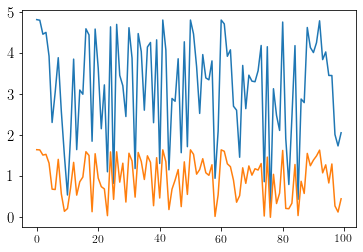

standard:  1.3336674297768019 inverse softmax:  0.4108393782445486
(1.3336674297768019, 0.4108393782445486)
[3.6 2.4 1.8]
a:  [3.6 2.4 1.8]
[0.54166667 0.29166667 0.16666667] [0.54166667 0.29166667 0.16666667]
[[0.11284722 0.         0.        ]
 [0.         0.06076389 0.        ]
 [0.         0.         0.03472222]]


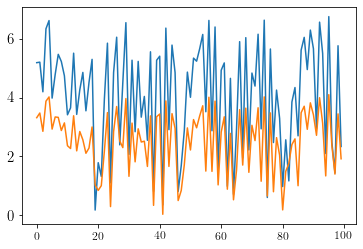

standard:  0.5048573733912678 inverse softmax:  0.26287047072398606
(0.5048573733912678, 0.26287047072398606)
[4.8 3.2 2.4]
a:  [4.8 3.2 2.4]
[0.51351351 0.2972973  0.18918919] [0.51351351 0.2972973  0.18918919]
[[0.06939372 0.         0.        ]
 [0.         0.04017531 0.        ]
 [0.         0.         0.02556611]]


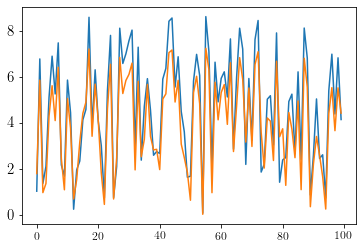

standard:  0.15445869966928272 inverse softmax:  0.19693450846047308
(0.15445869966928272, 0.19693450846047308)
[6. 4. 3.]
a:  [6. 4. 3.]
[0.5 0.3 0.2] [0.5 0.3 0.2]
[[0.05 0.   0.  ]
 [0.   0.03 0.  ]
 [0.   0.   0.02]]


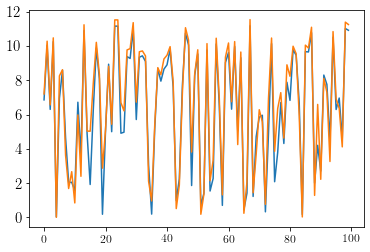

standard:  -0.06333423136343665 inverse softmax:  0.16487676392493333
(-0.06333423136343665, 0.16487676392493333)
[7.2 4.8 3.6]
a:  [7.2 4.8 3.6]
[0.49206349 0.3015873  0.20634921] [0.49206349 0.3015873  0.20634921]
[[0.03905266 0.         0.        ]
 [0.         0.0239355  0.        ]
 [0.         0.         0.01637692]]


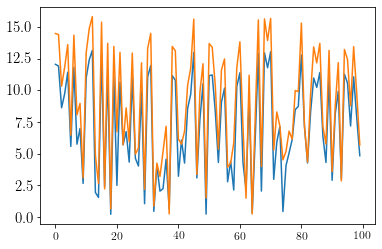

standard:  -0.21664773619348549 inverse softmax:  0.12267992950974271
(-0.21664773619348549, 0.12267992950974271)
[8.4 5.6 4.2]
a:  [8.4 5.6 4.2]
[0.48684211 0.30263158 0.21052632] [0.48684211 0.30263158 0.21052632]
[[0.03202909 0.         0.        ]
 [0.         0.01990997 0.        ]
 [0.         0.         0.01385042]]


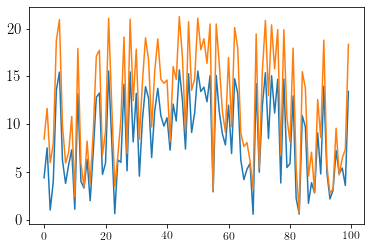

standard:  -0.3402377849280108 inverse softmax:  0.1058655309626266
(-0.3402377849280108, 0.1058655309626266)
[9.6 6.4 4.8]
a:  [9.6 6.4 4.8]
[0.48314607 0.30337079 0.21348315] [0.48314607 0.30337079 0.21348315]
[[0.02714304 0.         0.        ]
 [0.         0.0170433  0.        ]
 [0.         0.         0.01199344]]


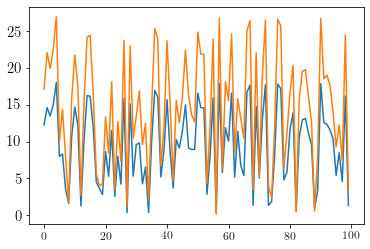

standard:  -0.4370783130176511 inverse softmax:  0.0950732674995567
(-0.4370783130176511, 0.0950732674995567)
[10.8  7.2  5.4]
a:  [10.8  7.2  5.4]
[0.48039216 0.30392157 0.21568627] [0.48039216 0.30392157 0.21568627]
[[0.02354864 0.         0.        ]
 [0.         0.01489812 0.        ]
 [0.         0.         0.01057286]]


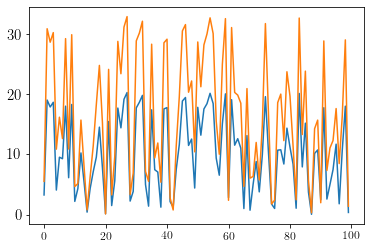

standard:  -0.5163975056815303 inverse softmax:  0.0827108726088042
(-0.5163975056815303, 0.0827108726088042)
[12.  8.  6.]
a:  [12.  8.  6.]
[0.47826087 0.30434783 0.2173913 ] [0.47826087 0.30434783 0.2173913 ]
[[0.02079395 0.         0.        ]
 [0.         0.01323251 0.        ]
 [0.         0.         0.0094518 ]]


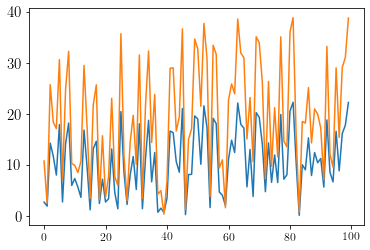

standard:  -0.5802632109435912 inverse softmax:  0.0842549613126014
(-0.5802632109435912, 0.0842549613126014)
seed:  8
[1.2 0.8 0.6]
a:  [1.2 0.8 0.6]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  0.3663068482709592
(nan, 0.3663068482709592)
[2.4 1.6 1.2]
a:  [2.4 1.6 1.2]
[0.63636364 0.27272727 0.09090909] [0.63636364 0.27272727 0.09090909]
[[0.2892562  0.         0.        ]
 [0.         0.12396694 0.        ]
 [0.         0.         0.04132231]]


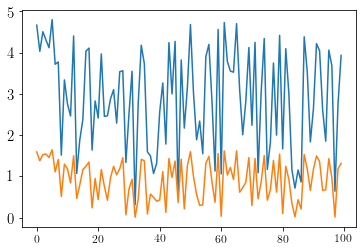

standard:  1.3433659745826707 inverse softmax:  0.386064591016287
(1.3433659745826707, 0.386064591016287)
[3.6 2.4 1.8]
a:  [3.6 2.4 1.8]
[0.54166667 0.29166667 0.16666667] [0.54166667 0.29166667 0.16666667]
[[0.11284722 0.         0.        ]
 [0.         0.06076389 0.        ]
 [0.         0.         0.03472222]]


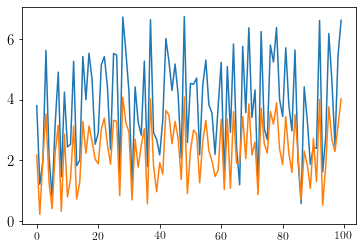

standard:  0.5103421697116857 inverse softmax:  0.26561798722538743
(0.5103421697116857, 0.26561798722538743)
[4.8 3.2 2.4]
a:  [4.8 3.2 2.4]
[0.51351351 0.2972973  0.18918919] [0.51351351 0.2972973  0.18918919]
[[0.06939372 0.         0.        ]
 [0.         0.04017531 0.        ]
 [0.         0.         0.02556611]]


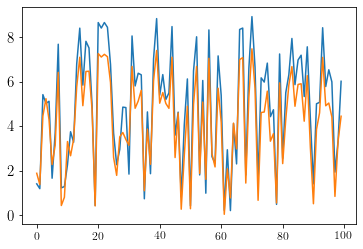

standard:  0.15636710905108192 inverse softmax:  0.20379566434849442
(0.15636710905108192, 0.20379566434849442)
[6. 4. 3.]
a:  [6. 4. 3.]
[0.5 0.3 0.2] [0.5 0.3 0.2]
[[0.05 0.   0.  ]
 [0.   0.03 0.  ]
 [0.   0.   0.02]]


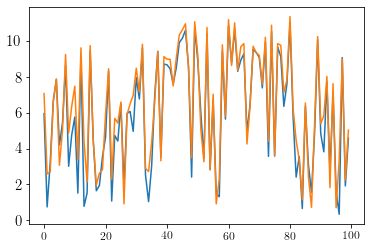

standard:  -0.06441678164856118 inverse softmax:  0.15137208392121826
(-0.06441678164856118, 0.15137208392121826)
[7.2 4.8 3.6]
a:  [7.2 4.8 3.6]
[0.49206349 0.3015873  0.20634921] [0.49206349 0.3015873  0.20634921]
[[0.03905266 0.         0.        ]
 [0.         0.0239355  0.        ]
 [0.         0.         0.01637692]]


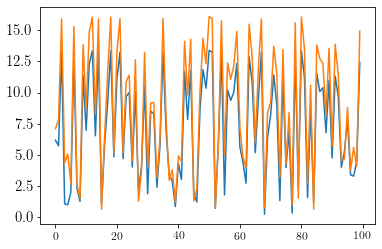

standard:  -0.21772578479655313 inverse softmax:  0.12505094083071108
(-0.21772578479655313, 0.12505094083071108)
[8.4 5.6 4.2]
a:  [8.4 5.6 4.2]
[0.48684211 0.30263158 0.21052632] [0.48684211 0.30263158 0.21052632]
[[0.03202909 0.         0.        ]
 [0.         0.01990997 0.        ]
 [0.         0.         0.01385042]]


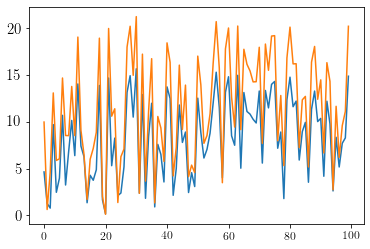

standard:  -0.33123771379515393 inverse softmax:  0.10966705828536864
(-0.33123771379515393, 0.10966705828536864)
[9.6 6.4 4.8]
a:  [9.6 6.4 4.8]
[0.48314607 0.30337079 0.21348315] [0.48314607 0.30337079 0.21348315]
[[0.02714304 0.         0.        ]
 [0.         0.0170433  0.        ]
 [0.         0.         0.01199344]]


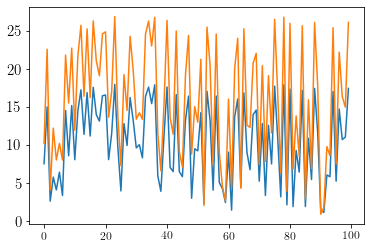

standard:  -0.43350795599245767 inverse softmax:  0.0851197930842849
(-0.43350795599245767, 0.0851197930842849)
[10.8  7.2  5.4]
a:  [10.8  7.2  5.4]
[0.48039216 0.30392157 0.21568627] [0.48039216 0.30392157 0.21568627]
[[0.02354864 0.         0.        ]
 [0.         0.01489812 0.        ]
 [0.         0.         0.01057286]]


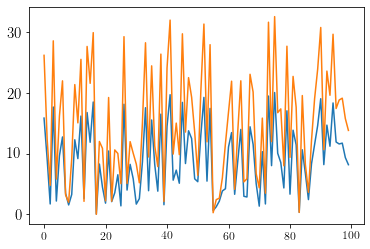

standard:  -0.5108364112700471 inverse softmax:  0.08586356769292511
(-0.5108364112700471, 0.08586356769292511)
[12.  8.  6.]
a:  [12.  8.  6.]
[0.47826087 0.30434783 0.2173913 ] [0.47826087 0.30434783 0.2173913 ]
[[0.02079395 0.         0.        ]
 [0.         0.01323251 0.        ]
 [0.         0.         0.0094518 ]]


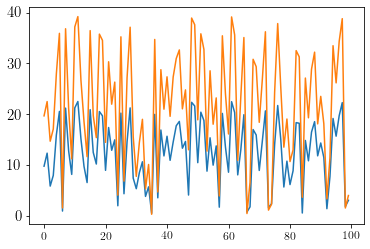

standard:  -0.5831217486939763 inverse softmax:  0.08003184820053022
(-0.5831217486939763, 0.08003184820053022)
seed:  9
[1.2 0.8 0.6]
a:  [1.2 0.8 0.6]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  0.4211949371521156
(nan, 0.4211949371521156)
[2.4 1.6 1.2]
a:  [2.4 1.6 1.2]
[0.63636364 0.27272727 0.09090909] [0.63636364 0.27272727 0.09090909]
[[0.2892562  0.         0.        ]
 [0.         0.12396694 0.        ]
 [0.         0.         0.04132231]]


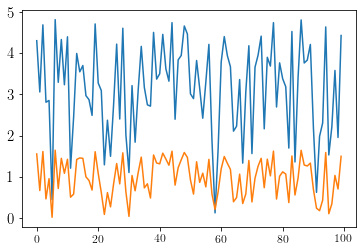

standard:  1.3252098080650354 inverse softmax:  0.3831643334698913
(1.3252098080650354, 0.3831643334698913)
[3.6 2.4 1.8]
a:  [3.6 2.4 1.8]
[0.54166667 0.29166667 0.16666667] [0.54166667 0.29166667 0.16666667]
[[0.11284722 0.         0.        ]
 [0.         0.06076389 0.        ]
 [0.         0.         0.03472222]]


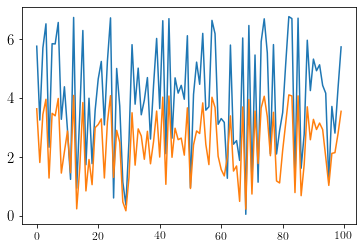

standard:  0.5075485997558333 inverse softmax:  0.2817141437708371
(0.5075485997558333, 0.2817141437708371)
[4.8 3.2 2.4]
a:  [4.8 3.2 2.4]
[0.51351351 0.2972973  0.18918919] [0.51351351 0.2972973  0.18918919]
[[0.06939372 0.         0.        ]
 [0.         0.04017531 0.        ]
 [0.         0.         0.02556611]]


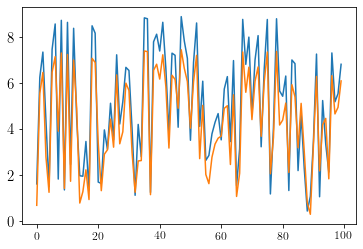

standard:  0.16053478039886523 inverse softmax:  0.20420213743252422
(0.16053478039886523, 0.20420213743252422)
[6. 4. 3.]
a:  [6. 4. 3.]
[0.5 0.3 0.2] [0.5 0.3 0.2]
[[0.05 0.   0.  ]
 [0.   0.03 0.  ]
 [0.   0.   0.02]]


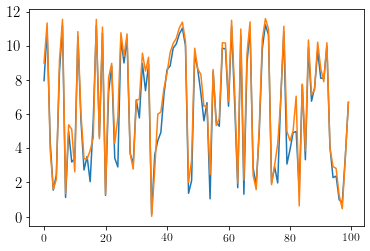

standard:  -0.06613495117945538 inverse softmax:  0.15297331878577397
(-0.06613495117945538, 0.15297331878577397)
[7.2 4.8 3.6]
a:  [7.2 4.8 3.6]
[0.49206349 0.3015873  0.20634921] [0.49206349 0.3015873  0.20634921]
[[0.03905266 0.         0.        ]
 [0.         0.0239355  0.        ]
 [0.         0.         0.01637692]]


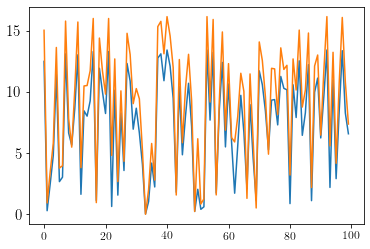

standard:  -0.21893530661578567 inverse softmax:  0.13475922600083093
(-0.21893530661578567, 0.13475922600083093)
[8.4 5.6 4.2]
a:  [8.4 5.6 4.2]
[0.48684211 0.30263158 0.21052632] [0.48684211 0.30263158 0.21052632]
[[0.03202909 0.         0.        ]
 [0.         0.01990997 0.        ]
 [0.         0.         0.01385042]]


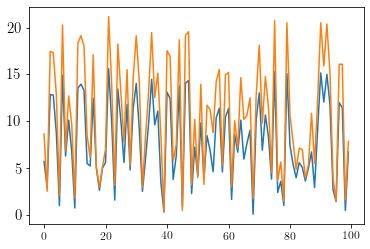

standard:  -0.3386048825201777 inverse softmax:  0.11453382651400353
(-0.3386048825201777, 0.11453382651400353)
[9.6 6.4 4.8]
a:  [9.6 6.4 4.8]
[0.48314607 0.30337079 0.21348315] [0.48314607 0.30337079 0.21348315]
[[0.02714304 0.         0.        ]
 [0.         0.0170433  0.        ]
 [0.         0.         0.01199344]]


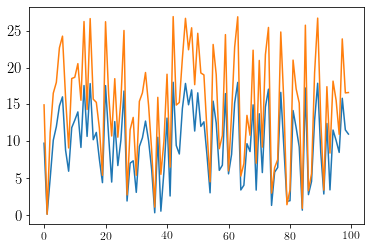

standard:  -0.43118079942377474 inverse softmax:  0.09347315282104537
(-0.43118079942377474, 0.09347315282104537)
[10.8  7.2  5.4]
a:  [10.8  7.2  5.4]
[0.48039216 0.30392157 0.21568627] [0.48039216 0.30392157 0.21568627]
[[0.02354864 0.         0.        ]
 [0.         0.01489812 0.        ]
 [0.         0.         0.01057286]]


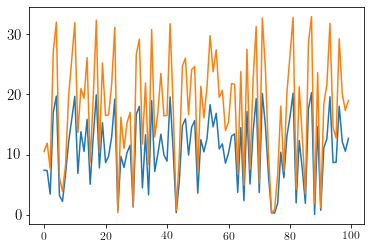

standard:  -0.5115234305662484 inverse softmax:  0.08733232644494723
(-0.5115234305662484, 0.08733232644494723)
[12.  8.  6.]
a:  [12.  8.  6.]
[0.47826087 0.30434783 0.2173913 ] [0.47826087 0.30434783 0.2173913 ]
[[0.02079395 0.         0.        ]
 [0.         0.01323251 0.        ]
 [0.         0.         0.0094518 ]]


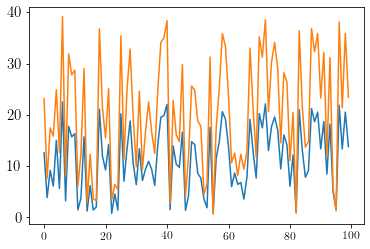

standard:  -0.57846178784325 inverse softmax:  0.07883996536226055
(-0.57846178784325, 0.07883996536226055)


In [369]:
KL_results_linear = []

for s in range(10):
    print("seed: ", s)
    np.random.seed(s)
    
    results_seed = []
    for a_ in As:
        print(a_)
        KL_ = KL_div_samples_combinations3([a_], verbose=True, num_samples=10000)
        print(KL_)
        results_seed.append(KL_)
    
    KL_results_linear.append(results_seed)

In [370]:
# handle the data
KL_results_linear = np.array(KL_results_linear)

# take the mean over the 10 seeds
KL_results_linear_mean = KL_results_linear.mean(0)
print(np.shape(KL_results_linear_mean))

(10, 2)


In [371]:
KL_results_linear_mean

array([[        nan,  0.38716617],
       [ 1.33245217,  0.39777697],
       [ 0.50543919,  0.27148833],
       [ 0.15512029,  0.19991244],
       [-0.06385358,  0.15449104],
       [-0.21766764,  0.12877182],
       [-0.33649938,  0.10978815],
       [-0.43264135,  0.09665232],
       [-0.51216011,  0.08511367],
       [-0.58212391,  0.07527854]])

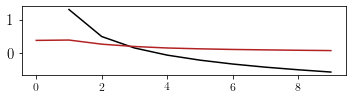

In [372]:
# make plots

fig = plt.figure(figsize=(5, 1.5))
plt.plot(KL_results_linear_mean[:,0], label='standard', color='black')
plt.plot(KL_results_linear_mean[:,1], label='softmax', color='firebrick')
#plt.legend()
plt.tight_layout()

#"""
tpl.save(
    "KL_Dirichlet.tex",
    figure = fig,
    axis_width = "\\figwidth",
    axis_height= "\\figheight",
    tex_relative_path_to_data=".",
    override_externals=False,
    float_format=".3g"
)
#"""

#plt.savefig('KL_Dirichlet.pdf')

plt.show();

# calculate MMD for growing a_i and plot it

In [362]:
MMD_results_linear = []

for s in range(10):
    print("seed: ", s)
    np.random.seed(s)
    
    results_seed = []
    for a_ in As:
        print(a_)
        MMD_ = MMD_combinations(params = [a_], n_samples=2000)
        print(MMD_)
        results_seed.append(MMD_)
    
    MMD_results_linear.append(results_seed)

seed:  0
[0.9 0.6 0.3]
a:  [0.9 0.6 0.3]
a_i < 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan softmax:  0.029559239745140076
(tensor([nan]), tensor([0.0296]))
[1.8 1.2 0.6]
a:  [1.8 1.2 0.6]
a_i < 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan softmax:  0.017481595277786255
(tensor([nan]), tensor([0.0175]))
[2.7 1.8 0.9]
a:  [2.7 1.8 0.9]
a_i < 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan softmax:  0.012979000806808472
(tensor([nan]), tensor([0.0130]))
[3.6 2.4 1.2]
a:  [3.6 2.4 1.2]
standard:  0.027932822704315186 softmax:  0.006814002990722656
(tensor([0.0279]), tensor([0.0068]))
[4.5 3.  1.5]
a:  [4.5 3.  1.5]
standard:  0.01583230495452881 softmax:  0.00297623872756958
(tensor([0.0158]), tensor([0.0030]))
[5.4 3.6 1.8]
a:  [5.4 3.6 1.8]
standard:  0.008881211280822754 softmax:  0.0031847357749938965
(tensor([0.0089]), tensor([0.0032]))
[6.3 4.2 2.1]
a:  [6.3 4.2 2.1]
standard:  0.007078886032104492 soft

standard:  0.006480753421783447 softmax:  0.0036971569061279297
(tensor([0.0065]), tensor([0.0037]))
[7.2 4.8 2.4]
a:  [7.2 4.8 2.4]
standard:  0.004500329494476318 softmax:  0.0031737089157104492
(tensor([0.0045]), tensor([0.0032]))
[8.1 5.4 2.7]
a:  [8.1 5.4 2.7]
standard:  0.0033910274505615234 softmax:  0.0014896988868713379
(tensor([0.0034]), tensor([0.0015]))
[9. 6. 3.]
a:  [9. 6. 3.]
standard:  0.0026923418045043945 softmax:  0.003840804100036621
(tensor([0.0027]), tensor([0.0038]))
seed:  6
[0.9 0.6 0.3]
a:  [0.9 0.6 0.3]
a_i < 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan softmax:  0.023255914449691772
(tensor([nan]), tensor([0.0233]))
[1.8 1.2 0.6]
a:  [1.8 1.2 0.6]
a_i < 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan softmax:  0.017285585403442383
(tensor([nan]), tensor([0.0173]))
[2.7 1.8 0.9]
a:  [2.7 1.8 0.9]
a_i < 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan softmax:  0.012536168098449707
(t

In [363]:
# handle the data
MMD_results_linear = np.array(MMD_results_linear)

# take the mean over the 10 seeds
MMD_results_linear_mean = MMD_results_linear.mean(0)
print(np.shape(MMD_results_linear_mean))

(10, 2)


In [364]:
MMD_results_linear_mean

array([[       nan, 0.02448117],
       [       nan, 0.01661848],
       [       nan, 0.01090862],
       [0.0301125 , 0.00724956],
       [0.01596848, 0.00565417],
       [0.0095034 , 0.00441345],
       [0.00686924, 0.00360751],
       [0.00452125, 0.00333477],
       [0.00336032, 0.00308639],
       [0.00274405, 0.00246603]], dtype=float32)

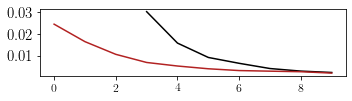

In [373]:
# make plots

fig = plt.figure(figsize=(5, 1.5))
plt.plot(MMD_results_linear_mean[:,0], label='standard', color='black')
plt.plot(MMD_results_linear_mean[:,1], label='softmax', color='firebrick')
#plt.legend()
plt.tight_layout()

#"""
tpl.save(
    "MMD_Dirichlet.tex",
    figure = fig,
    axis_width = "\\figwidth",
    axis_height= "\\figheight",
    tex_relative_path_to_data=".",
    override_externals=False,
    float_format=".3g"
)
#"""
#plt.savefig('MMD_Dirichlet.pdf')

plt.show();